# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
from peptdeep.pretrained_models import ModelManager
from peptdeep import settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn.metrics as sk
import sklearn.linear_model as sk_lm
from alphabase.psm_reader import psm_reader_provider

#%run methods_freshfrozen.ipynb

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Input

In [3]:
# Functions used on the original df to get the df_base(manipulate 'Scan number' and 'Modified Sequence')
# needs to be run whenever _fill_modified_sequence_ was renderedetyl (Protein N-term),2 Oxidation (M)', 'Acetyl (Protein N-term),3 Oxidation (M)', 'Oxidation (M)',
%run methods_freshfrozen.ipynb
#df = pd.read_csv("evidence_freshfrozen.txt",  sep="\t")
df_base  = fill_modified_sequence(df)
df_base['MS/MS scan number'] = df_base['MS/MS scan number'].fillna(-1)
df_base = df_base.dropna(subset = ['Modified sequence'])
df_base.to_csv("evidence_freshfrozen_base.txt", sep='\t', index=False)

C:\Users\cocob\AppData\Local\Temp\ipykernel_17148\769990480.py:4: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("evidence_freshfrozen.txt",  sep="\t")


In [2]:
# max quant to alpha base
df = pd.read_csv("evidence_freshfrozen_base.txt",  sep="\t")
# introduce original index column to be able to merge alpha_base_df back into their original max_quant_df
df.loc[:,'Original index'] = df.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df)
mq_reader._transform_table(df)
mq_reader._translate_decoy(df)
mq_reader._translate_score(df)
mq_reader._load_modifications(df)
mq_reader._translate_modifications()
mq_reader._post_process(df)  
df_comp = mq_reader.psm_df


C:\Users\cocob\AppData\Local\Temp\ipykernel_15064\3762353592.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("evidence_freshfrozen_base.txt",  sep="\t")


In [ ]:
# merging alpha base format back to MaxQuant
df_ab = pd.read_csv('comparisons/comp_all_trans.txt', sep = '\t')
df_comp['ccs_pred'] = df_ab['ccs_pred']
df_comp['mobility_pred'] = df_ab['mobility_pred']
mapping_dict = {
            'sequence': 'Sequence',
            'charge': 'Charge',
            'rt': 'Retention time',
            'ccs': 'CCS',
            'mobility': '1/K0',
            'scan_num': 'MS/MS scan number',
            'raw_name': 'Raw file',
            'precursor_mz': 'm/z',
            'score': 'Score',
            'proteins': 'Proteins',
            'genes': 'Gene names',
            'decoy': 'Reverse',
            'intensity': 'Intensity',
            'nAA':'Length'}
merging_list = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity' ]
        # rename the columns of the alphabase dataframe according to the mapping dict
df_comp.rename(columns=mapping_dict, inplace=True)
        # set the original index as index
df_comp.set_index('Original index', inplace=True)
df_merged = pd.merge(df, df_comp, on = merging_list, how = 'inner')
df_merged.to_csv('comparisons/comp__trans_orig.txt', sep = '\t')

# Load Model

In [3]:
# load model
models = ModelManager(device = 'gpu')
models.load_installed_models()
#ccs_model = models.ccs_model

In [31]:
# settings of the model
settings = settings.global_settings
for key, value in settings.items():
    print(key)
    print(f"\t{value}")

model
	{'frag_types': ['b', 'y', 'b_modloss', 'y_modloss'], 'max_frag_charge': 2}
PEPTDEEP_HOME
	C:\Users\cocob/peptdeep
local_model_zip_name
	pretrained_models.zip
model_url
	https://github.com/MannLabs/alphapeptdeep/releases/download/pre-trained-models/pretrained_models.zip
task_workflow
	['library']
task_choices
	['train', 'library']
thread_num
	16
MAX_THREADS
	60
torch_device
	{'device_type': 'gpu', 'device_type_choices': ['get_available', 'gpu', 'mps', 'cpu'], 'device_ids': []}
log_level
	info
log_level_choices
	['debug', 'info', 'warning', 'error', 'critical']
common
	{'modloss_importance_level': 1.0, 'user_defined_modifications': {}}
peak_matching
	{'ms2_ppm': True, 'ms2_tol_value': 20.0, 'ms1_ppm': True, 'ms1_tol_value': 20.0}
model_mgr
	{'default_nce': 30.0, 'default_instrument': 'Lumos', 'mask_modloss': True, 'model_type': 'generic', 'model_choices': ['generic', 'phos', 'hla', 'digly'], 'external_ms2_model': '', 'external_rt_model': '', 'external_ccs_model': '', 'charge_model

TODO: AlphaPeptDeep offers multiple models. For every 3 Models or just one pretrained model per Measurement to predict?

-did sequences longer than 35 AA predicted(in settings max is 35?)<br>
No max nAA is 55 (settings not that important)

# Prediction

In [42]:
df_base = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_15808\1373096629.py:1: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base = pd.read_csv('evidence_freshfrozen_base.txt', sep = '\t')


In [44]:
# alphabase from Maxquant
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader._translate_columns(df_base)
mq_reader._transform_table(df_base)
mq_reader._translate_decoy(df_base)
mq_reader._translate_score(df_base)
mq_reader._load_modifications(df_base)
mq_reader._translate_modifications()
mq_reader._post_process(df_base)
df_mods = mq_reader.psm_df

In [37]:
# get input for prediction
mod = 'Acetyl@Protein N-term;Oxidation@M'# Acetyl@Protein N-term, Oxidation@M (if several use ; , Acetyl first, unmod = '')

# use AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
#mq_reader.fixed_C57 = False # This line excludes all the Carboi... Modifications at C's
df_mods = mq_reader.import_file("evidence_freshfrozen_base.txt")
df_mods = df_mods[df_mods['mods']== mod]

# Remove experimental CCS and IM from the input for the prediction
#df_in = df_mods.drop(labels=['ccs','mobility'], axis=1)

 What Input Columns are actually necessary for the prediction
 sequence, mods, mod_site, charge

TODO: Use the Measurements for which no Modified sequence exists? (They do get predicted)(Do they get predicted as unmodified??) ( use them in the dataset? or drop)

TODO: Check out if retraining the model is inplace( create tool)

TODO: Check the Bachelor Thesis Titles (Mail)

In [5]:
# predict
prediction = models.predict_mobility(df_in)
#prediction = models.predict_mobility(df_in)

2024-07-24 13:12:03> Predicting mobility ...


100%|██████████| 40/40 [02:18<00:00,  3.46s/it]


In [23]:
# write prediction to csv
# what Modification to look at [pred_all, pred_unmod, pred_ac, pred_ac_ox, pred_ac_2ox, pred_ox, pred_2ox, pred_3ox, pred_4ox]
name = 'pred_ac'
prediction.to_csv(f'predictions/{name}.txt', sep='\t', index=False)    

# Evaluation

In [2]:
df_comp = pd.read_csv('comparisons/comp_all.txt', sep='\t')

In [17]:
for i in range (1,5):
    print(f"Number of measurements with Charge {i}: {len(df_comp[df_comp['charge']==i])}")

Number of measurements with Charge 1: 11
Number of measurements with Charge 2: 991643
Number of measurements with Charge 3: 332901
Number of measurements with Charge 4: 72013


In [24]:
# loop over all modifications
%run evaluation_methods.ipynb
names = ['all', 'unmod', 'ac', 'ac_ox', 'ac_2ox', 'ox', '2ox', '3ox', '4ox']
mods_alpha = ['','Acetyl@Protein N-term','Acetyl@Protein N-term;Oxidation@M', 'Acetyl@Protein N-term;Oxidation@M;Oxidation@M','Oxidation@M', 'Oxidation@M;Oxidation@M', 'Oxidation@M;Oxidation@M;Oxidation@M', 'Oxidation@M;Oxidation@M;Oxidation@M;Oxidation@M']# Acetyl@Protein N-term, Oxidation@M (if several use ; , Acetyl first, unmod = '')
mods_original = ['Unmodified', 'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),Oxidation (M)', 'Acetyl (Protein N-term),2 Oxidation (M)', 'Oxidation (M)',
            '2 Oxidation (M)', '3 Oxidation (M)', '4 Oxidation (M)']
i = -1
for name in names:
    print(f'Modification:{name}, {i}, {mods_original[i]}, {mods_alpha[i]}')
    if i >-1:
        df_mods = df[df['Modifications']== mods_original[i]]
    else:
        df_mods = df
    df_mods = fill_modified_sequence(df_mods)
    df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
    df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)
    df_mods.to_csv('example_alpha_base.txt', sep='\t')
    mq_reader = psm_reader_provider.get_reader('maxquant')
    #mq_reader.fixed_C57 = False # This line excludes all the Carboi... Modifications at C's
    df_mods = mq_reader.import_file('example_alpha_base.txt')
    df_in = df_mods.drop(labels=['ccs','mobility'], axis=1)
    prediction = models.predict_mobility(df_in)
    prediction.to_csv(f'predictions/{name}.txt', sep='\t', index=False)   

    i +=1

Modification:all, -1, 4 Oxidation (M), Oxidation@M;Oxidation@M;Oxidation@M;Oxidation@M
2024-06-15 16:49:52> Predicting mobility ...


100%|██████████| 46/46 [21:24<00:00, 27.93s/it]


Modification:unmod, 0, Unmodified, 


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:24:05> Predicting mobility ...


100%|██████████| 46/46 [13:46<00:00, 17.98s/it]


Modification:ac, 1, Acetyl (Protein N-term), Acetyl@Protein N-term


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:38:27> Predicting mobility ...


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


Modification:ac_ox, 2, Acetyl (Protein N-term),Oxidation (M), Acetyl@Protein N-term;Oxidation@M


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:38:39> Predicting mobility ...


100%|██████████| 26/26 [00:01<00:00, 16.26it/s]
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


Modification:ac_2ox, 3, Acetyl (Protein N-term),2 Oxidation (M), Acetyl@Protein N-term;Oxidation@M;Oxidation@M
2024-06-15 17:38:40> Predicting mobility ...


100%|██████████| 17/17 [00:00<00:00, 37.53it/s]


Modification:ox, 4, Oxidation (M), Oxidation@M


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:39:18> Predicting mobility ...


100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


Modification:2ox, 5, 2 Oxidation (M), Oxidation@M;Oxidation@M


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:41:10> Predicting mobility ...


100%|██████████| 37/37 [00:10<00:00,  3.63it/s]


Modification:3ox, 6, 3 Oxidation (M), Oxidation@M;Oxidation@M;Oxidation@M


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)


2024-06-15 17:41:22> Predicting mobility ...


100%|██████████| 28/28 [00:02<00:00, 10.81it/s]


Modification:4ox, 7, 4 Oxidation (M), Oxidation@M;Oxidation@M;Oxidation@M;Oxidation@M
2024-06-15 17:41:25> Predicting mobility ...


C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['Modified sequence'] = df_mods['Modified sequence'].fillna('__')
C:\Users\cocob\AppData\Local\Temp\ipykernel_26928\917811807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods['MS/MS scan number'] = df_mods['MS/MS scan number'].fillna(-1)
100%|██████████| 7/7 [00:00<00:00, 17.01it/s]


In [29]:
names = ['all', 'unmod', 'ac', 'ac_ox', 'ac_2ox', 'ox', '2ox', '3ox', '4ox']

for name in names:
    df = pd.read_csv(f'predictions/{name}.txt',sep = '\t')
    print(f'Length of {name}: {len(df)}')
    

Length of all: 1396568
Length of unmod: 1226330
Length of ac: 9659
Length of ac_ox: 2411
Length of ac_2ox: 156
Length of ox: 146068
Length of 2ox: 11078
Length of 3ox: 814
Length of 4ox: 42


In [14]:
# relative Mean and Std for Pred
print(f'relative CCS error:{df_comp['ccs_diff'].abs().mean()/(df_comp['ccs'].max()-df_comp['ccs'].min())}')
print(f'relative IM error:{df_comp['IM_diff'].abs().mean()/(df_comp['mobility'].max()-df_comp['mobility'].min())}')
print(f'relative CCS standard deviation:{df_comp['ccs_diff'].std()/(df_comp['ccs'].max()-df_comp['ccs'].min())}')
print(f'relative IM standard deviation:{df_comp['IM_diff'].std()/(df_comp['mobility'].max()-df_comp['mobility'].min())}')

relative CCS difference:0.017121769955880394
relative IM difference:0.06859603309453885
relative CCS standard deviation:0.021698643051980313
relative IM standard deviation:0.07639753136472893


In [54]:
# absolute Mean and Std for Pred
print(f'CCS error:{df_comp['ccs_diff'].abs().mean()}')
print(f'IM error:{df_comp['IM_diff'].abs().mean()}')
print(f'CCS standard deviation:{df_comp['ccs_diff'].std()}')
print(f'IM standard deviation:{df_comp['IM_diff'].std()}')

relative CCS difference:15.691551778007224
relative IM difference:0.03597550638403467
relative CCS standard deviation:16.206596320755853
relative IM standard deviation:0.035435695259351724


In [7]:
# absolute Mean and Std for Pred
print(f'CCS error:{df_comp['ccs_diff'].mean()}')
print(f'IM error:{df_comp['IM_diff'].mean()}')
print(f'CCS standard deviation:{df_comp['ccs_diff'].std()}')
print(f'IM standard deviation:{df_comp['IM_diff'].std()}')

CCS error:-9.287576317477443
IM error:-0.020677852599147565
CCS standard deviation:18.31675215993022
IM standard deviation:0.03352866114785203


## Plots

### Data

In [12]:
df_comp = pd.read_csv('comparisons/comp_all.txt', sep = '\t')
print(len(df_comp))

1396568


In [2]:
df_comp = pd.read_csv('comparisons/comp_orig.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_11232\1461677234.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comp = pd.read_csv('comparisons/comp_orig.txt', sep = '\t')


In [2]:
df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_28976\4069564456.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comp = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')


In [3]:
df_comp['ccs_diff'] = np.subtract(df_comp['CCS'], df_comp['ccs_pred'])
df_comp['IM_diff'] = np.subtract(df_comp['1/K0'], df_comp['mobility_pred'])

In [ ]:
# experiment differences
df_51 = df_comp[df_comp["raw_name"].str.contains('P064051', na = False)]#P064051
print(len(df_51))
print(df_51['ccs_diff'].mean())
print(df_51['ccs_diff'].std())
df_64 = df_comp[df_comp["raw_name"].str.contains('P064064', na = False)]#P064064
print(len(df_64))
print(df_64['ccs_diff'].mean())
print(df_64['ccs_diff'].std())
df_28 = df_comp[df_comp["raw_name"].str.contains('P064428', na = False)]#P064428
print(len(df_28))
print(df_28['ccs_diff'].mean())
print(df_28['ccs_diff'].std())

505480
-4.19887957058071
17.947464121784716
436198
-15.792257559874658
16.55430967718992
454890
-8.704810116967838
18.429115555627593


In [15]:
# range CCS
print(df_comp['CCS'].min())
print(df_comp['CCS'].max())
print(df_comp['CCS'].max()-df_comp['CCS'].min())

190.575650614087
1034.71839797628
844.142747362193


In [13]:
# range 1/K0
print(df_comp['1/K0'].min())
print(df_comp['1/K0'].max())

0.854538535940709
1.29340953803871


In [17]:
print(df_comp[df_comp['Experiment']=='P064051']['IM_diff'].mean())
print(df_comp[df_comp['Experiment']=='P064064']['IM_diff'].mean())
print(df_comp[df_comp['Experiment']=='P064428']['IM_diff'].mean())

-0.009549253716858679
-0.03536425772665843
-0.018961181797875676


### Histograms

Text(0.5, 0, 'CCS Difference')

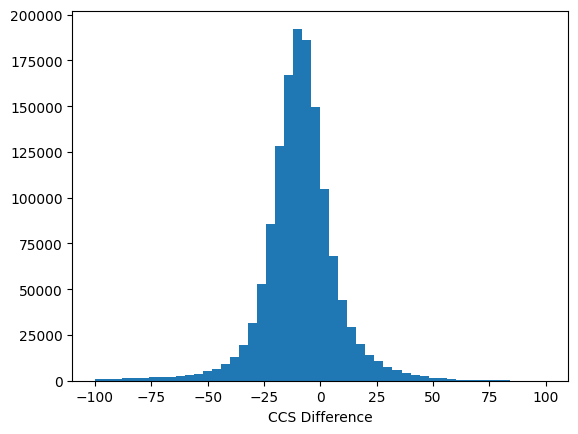

In [16]:
# histogram: CCS error
plt.hist(df_comp['ccs_diff'], range=(-100, 100), bins = 50)
plt.xlabel('CCS Difference')

Text(0.5, 1.0, 'Prediction Error')

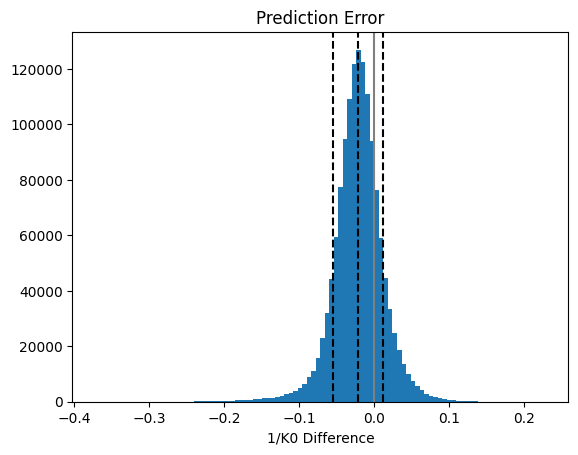

In [6]:
# histogram: IM error
plt.hist(df_comp['IM_diff'], bins = 100)
plt.xlabel('1/K0 Difference')
plt.axvline(x = 0.0, c = 'grey', linestyle = '-' )
plt.axvline(x = -0.0207, c = 'black', linestyle = '--' )
plt.axvline(x = -0.0542, c = 'black', linestyle = '--' )
plt.axvline(x = 0.0128, c = 'black', linestyle = '--' )
plt.title('Prediction Error')

1396568
-9.287576317477447
-0.020677852599147582
0.033528661147852044


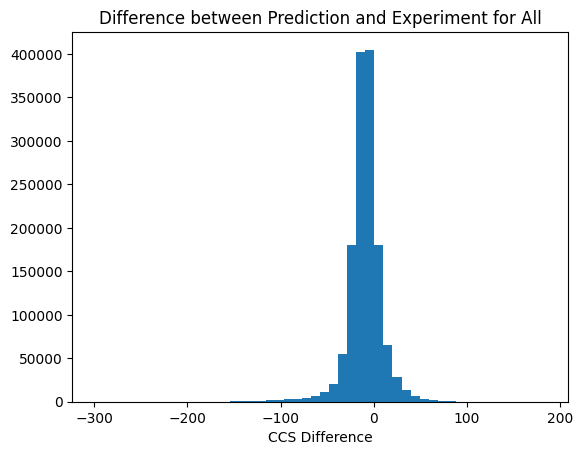

982229
-8.455785188290301
-0.019289167181537364
0.03222266839690138


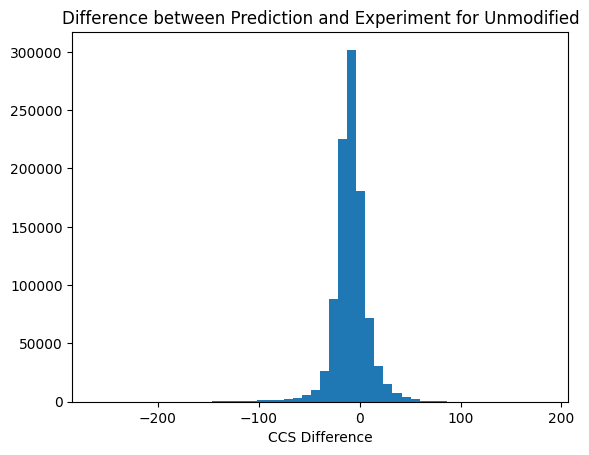

8037
-11.617290035224602
-0.02760990845531311
0.033857441275265306


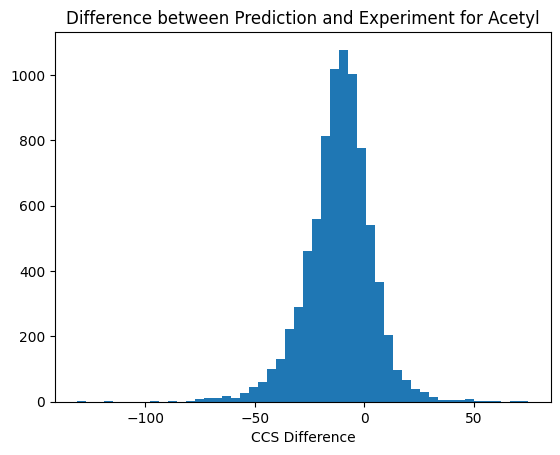

1975
-10.374811674409727
-0.024749869730245698
0.03217083898335926


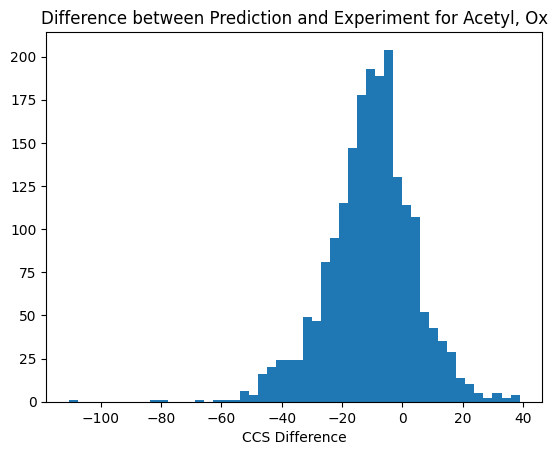

140
-11.108360196325716
-0.02539389085057525
0.031209503610124017


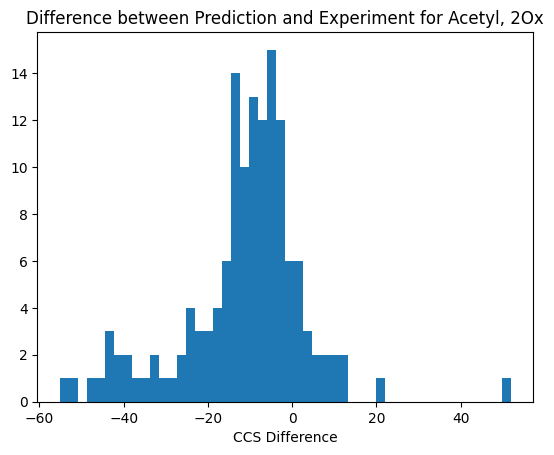

118355
-9.046846472422848
-0.020663397774616038
0.030016208837632723


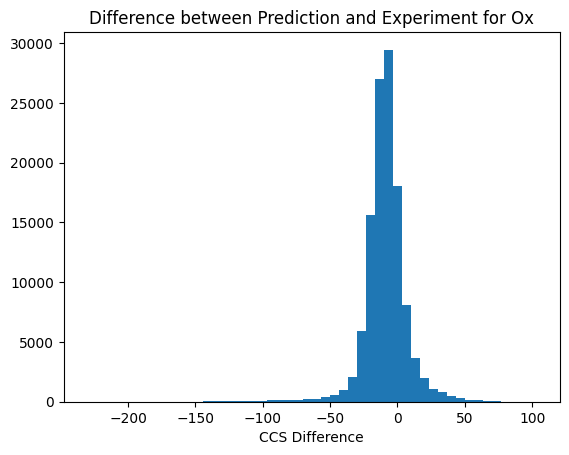

9402
-10.699668304835491
-0.0238317062484553
0.030550243879261314


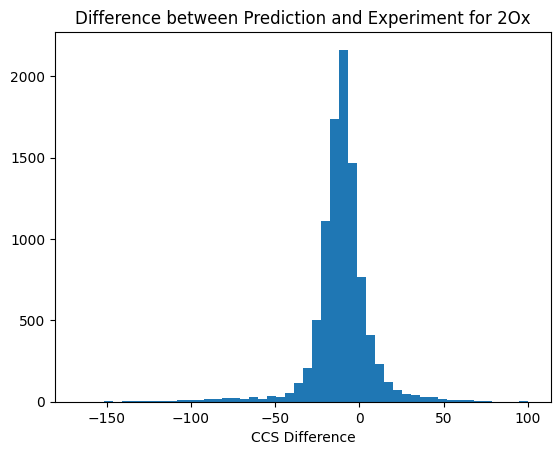

725
-10.466422959070691
-0.024581221927785973
0.026784229606556412


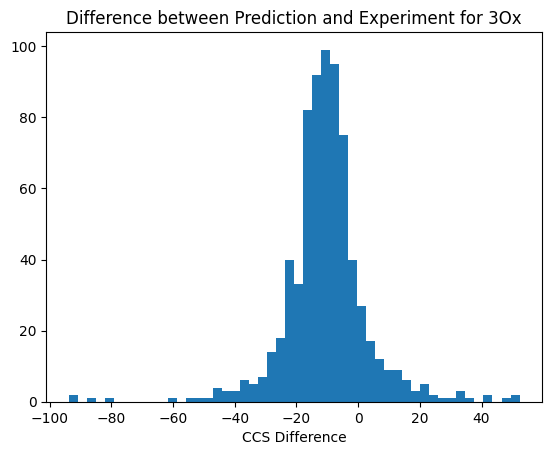

41
-7.10042368236698
-0.017598442294301013
0.01306447108041428


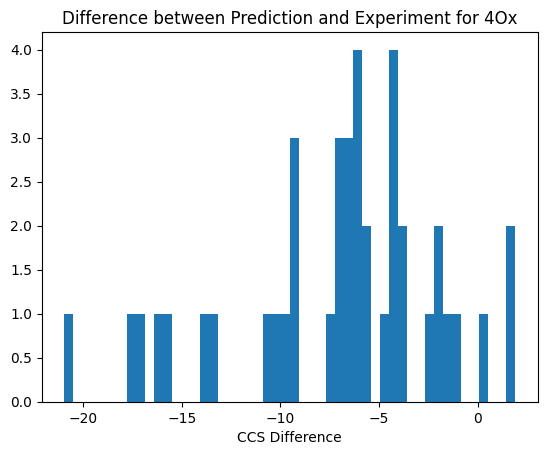

In [12]:
# Histograms: Plot Prediction Error across Modifications
# TODO: Check
mods_alpha = ['','Acetyl@Protein N-term','Acetyl@Protein N-term;Oxidation@M', 'Acetyl@Protein N-term;Oxidation@M;Oxidation@M','Oxidation@M', 'Oxidation@M;Oxidation@M', 'Oxidation@M;Oxidation@M;Oxidation@M', 'Oxidation@M;Oxidation@M;Oxidation@M;Oxidation@M']# Acetyl@Protein N-term, Oxidation@M (if several use ; , Acetyl first, unmod = '')
names = ['Unmodified', 'Acetyl', 'Acetyl, Ox','Acetyl, 2Ox', 'Ox', '2Ox', '3Ox', '4Ox']
i = -1
for i in range(-1,len(mods_alpha)):
    if i>0:
        df_comp_mods =  df_comp[df_comp['mods']==mods_alpha[i]]
        name = names[i]

    elif i == 0:
        df_comp_mods =  df_comp[df_comp['mods'].isna()]
        name = names[i]
    else:
        df_comp_mods = df_comp
        name = 'All'
    plt.hist(df_comp_mods['ccs_diff'], bins = 50)
    print((len(df_comp_mods)))
    print(df_comp_mods['ccs_diff'].mean())
    print(df_comp_mods['IM_diff'].mean())
    print(df_comp_mods['IM_diff'].std())
    plt.xlabel('CCS Difference')
    plt.title(f'Difference between Prediction and Experiment for {name}')    
    plt.show()

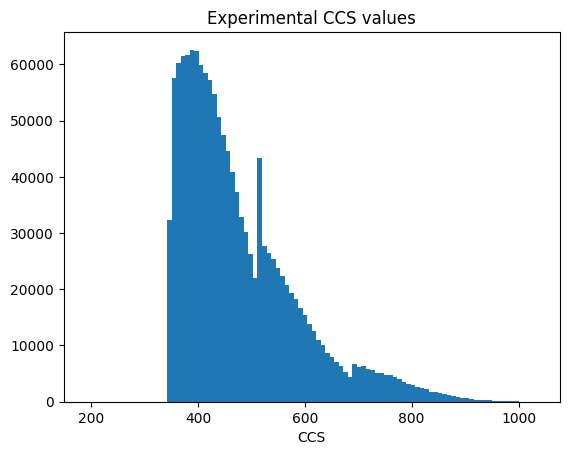

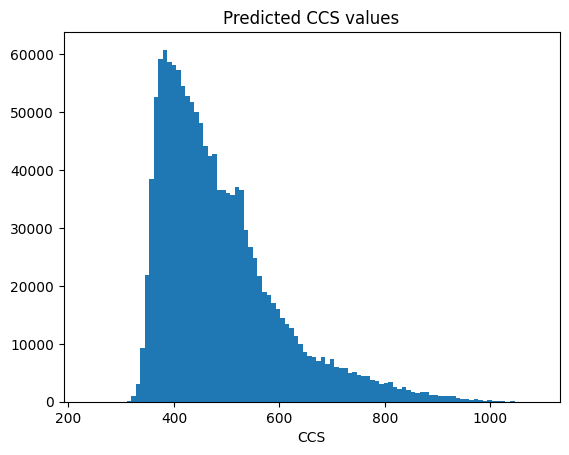

In [ ]:
# Distributions(Histrograms): CCS_exp and CCS_pred
plt.hist(df_comp['ccs'], bins = 100)
plt.xlabel('CCS')
plt.title(f'Experimental CCS values')    
plt.show()

plt.hist(df_comp['ccs_pred'], bins = 100)
plt.xlabel('CCS')
plt.title(f'Predicted CCS values')    
plt.show()

# TODO: look into spike at ~550

### Scatter Plots

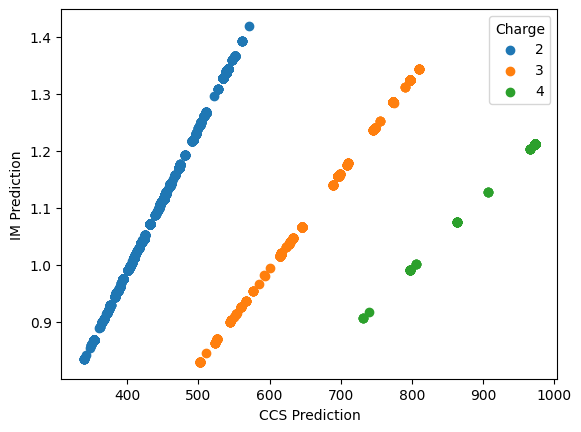

In [ ]:
# scatter plot:CCS pred/IM pred
groups = df_comp.groupby('Charge')
for name, group in groups:
    plt.scatter(y = group['mobility_pred'], x = group['ccs_pred'], label=name)
plt.ylabel('IM Prediction')
plt.xlabel('CCS Prediction')
plt.legend(title='Charge')
plt.show()

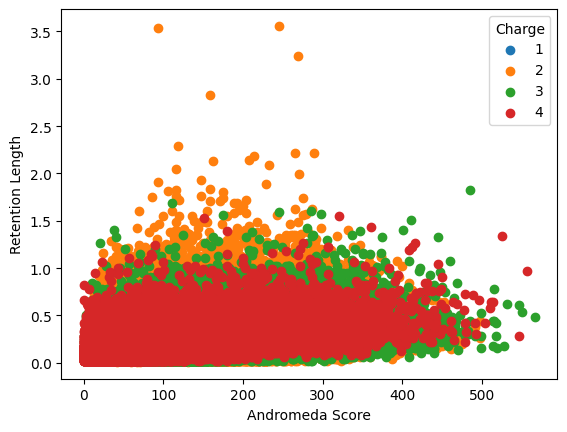

In [7]:
# scatter plot:RT length/Andromeda Score
groups = df_comp.groupby('Charge')
for name, group in groups:
    plt.scatter(y = group['Retention length'], x = group['Score'], label=name)
plt.ylabel('Retention Length')
plt.xlabel('Andromeda Score')
plt.legend(title='Charge')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


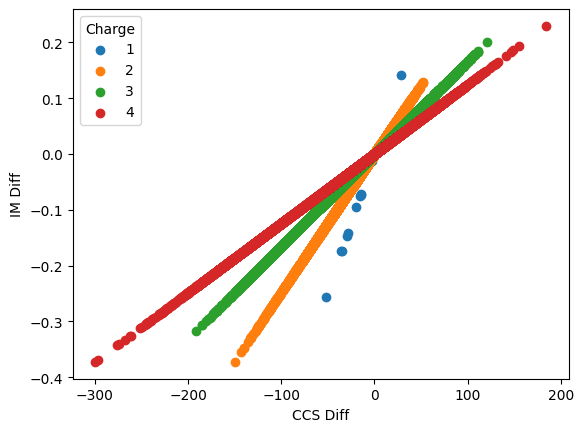

In [4]:
# scatter plot: CCS Diff vs IM Diff
groups = df_comp.groupby('Charge')
for name, group in groups:
    plt.scatter(y = group['IM_diff'], x = group['ccs_diff'], label=name)
plt.ylabel('IM Diff')
plt.xlabel('CCS Diff')
plt.legend(title='Charge')
plt.show()

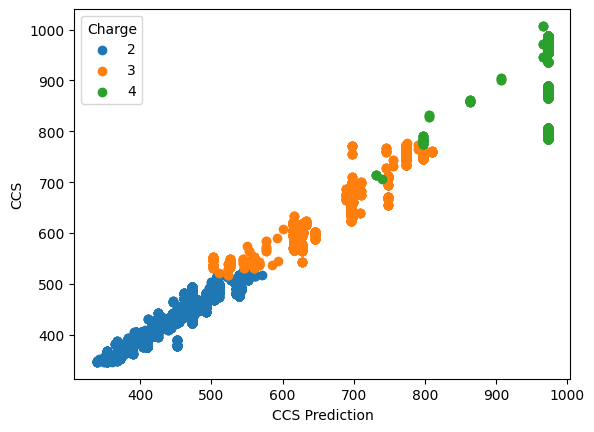

In [ ]:
# scatter plot: CCS pred vs CCS
groups = df_comp.groupby('Charge')
for name, group in groups:
    plt.scatter(y = group['CCS'], x = group['ccs_pred'], label=name)
plt.ylabel('CCS')
plt.xlabel('CCS Prediction')
plt.legend(title='Charge')
plt.show()
# TODO: investigate the green on the right edge

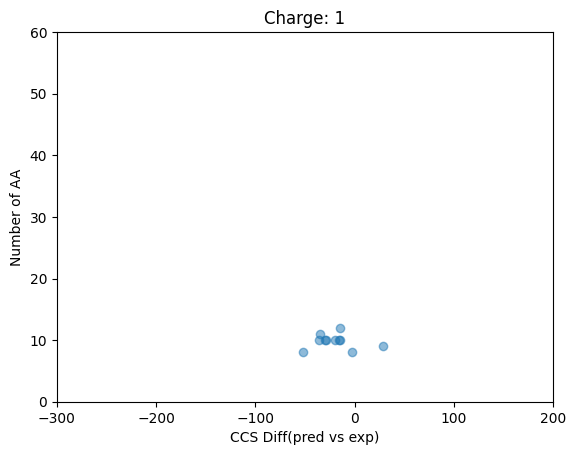

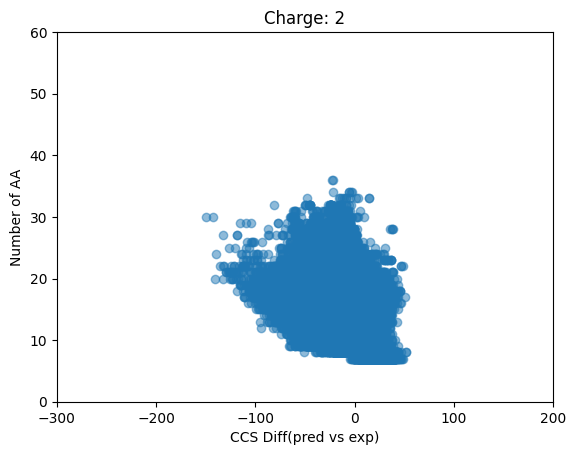

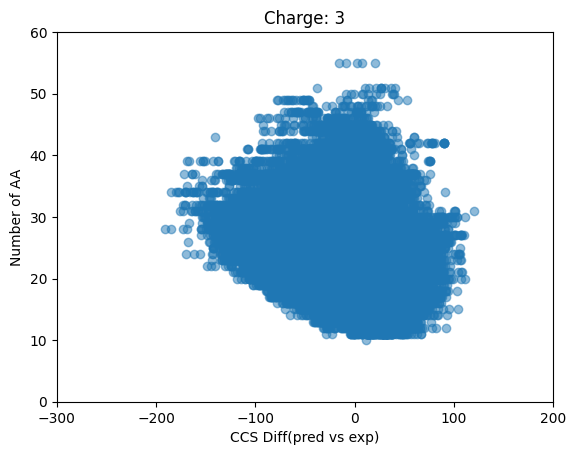

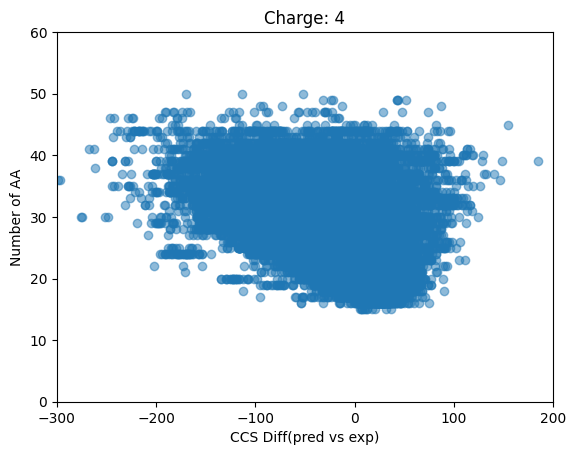

In [10]:
# scatter plot: number of AA vs. CCS error across all Charges
charges = [1,2,3,4]
for charge in charges:
    df_charge = df_comp[df_comp['charge']==charge]
    plt.scatter(y = df_charge['nAA'], x = df_charge['ccs_diff'], alpha = 0.5)
    plt.ylabel('Number of AA')
    plt.xlabel('CCS Diff(pred vs exp)')
    plt.xlim(-300,200)
    plt.ylim(0,60)
    plt.title(f'Charge: {charge}')
    plt.show()

#TODO: Check

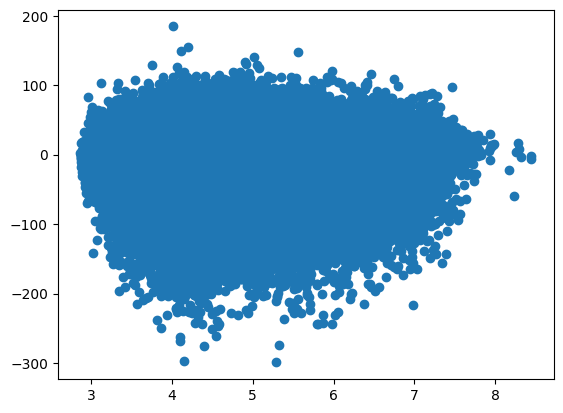

In [18]:
# scatter: intesity vs ccs_Diff
plt.scatter(x = np.log10(df_comp['intensity']), y=df_comp['ccs_diff'])

In [6]:
# scatter/kde: intensity vs ccs_Diff
df_comp['log_int'] = np.log10(df_comp['Intensity'])
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='log_int', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Log Intensity')
plt.ylabel('CCS Error')
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

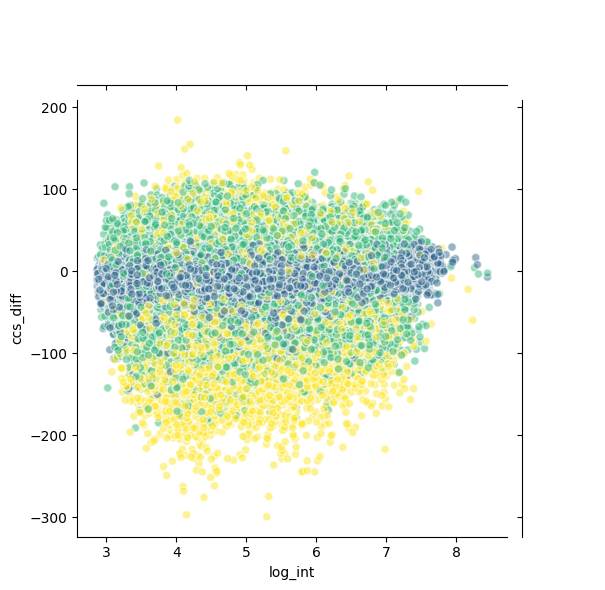

In [7]:
# scatter/kde: intensity vs ccs_Diff
df_comp['log_int'] = np.log10(df_comp['Intensity'])
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='log_int', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Log Intensity')
plt.ylabel('CCS Error')
plt.show()

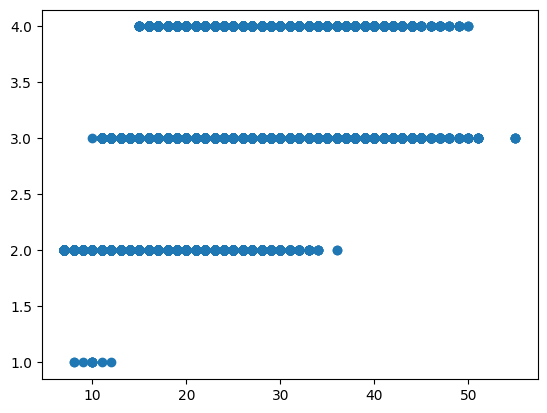

In [8]:
# scatter length vs charge state
plt.scatter(x = 'Length', y = 'Charge', data=df_comp)

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


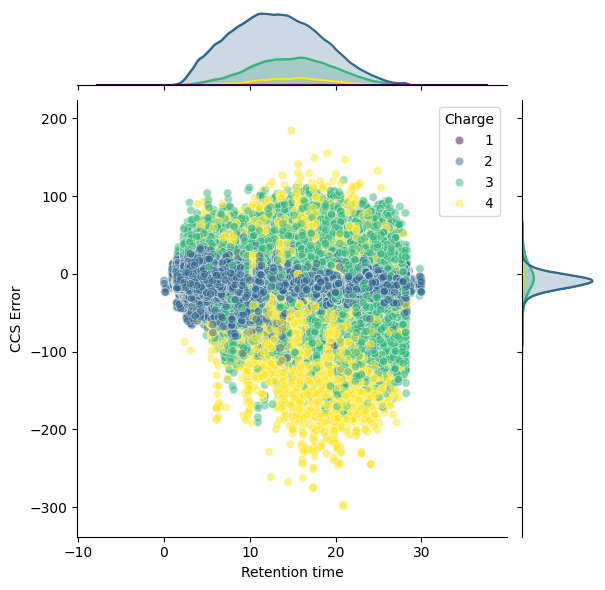

In [6]:
# scatter/kde: rt vs ccs_Diff, color charge
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Retention time', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Retention time')
plt.ylabel('CCS Error')
plt.show()

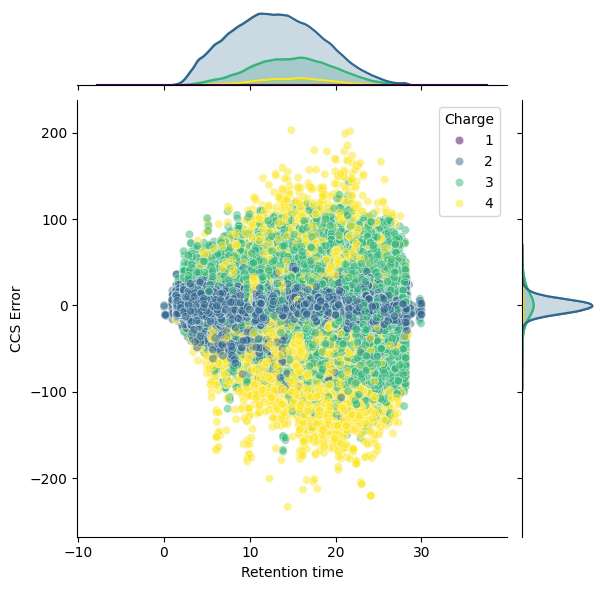

In [8]:
# scatter/kde: rt vs ccs_Diff, (after TL)
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Retention time', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Retention time')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


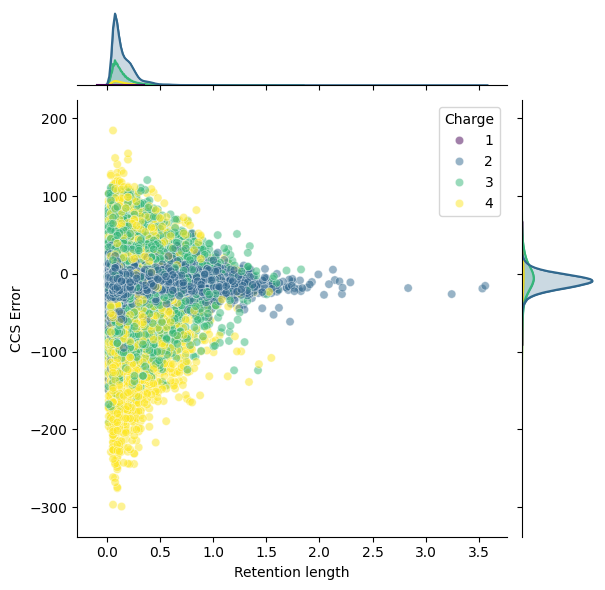

In [6]:
# scatter/kde: rt length vs ccs_Diff, color charge
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Retention length', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Retention length')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


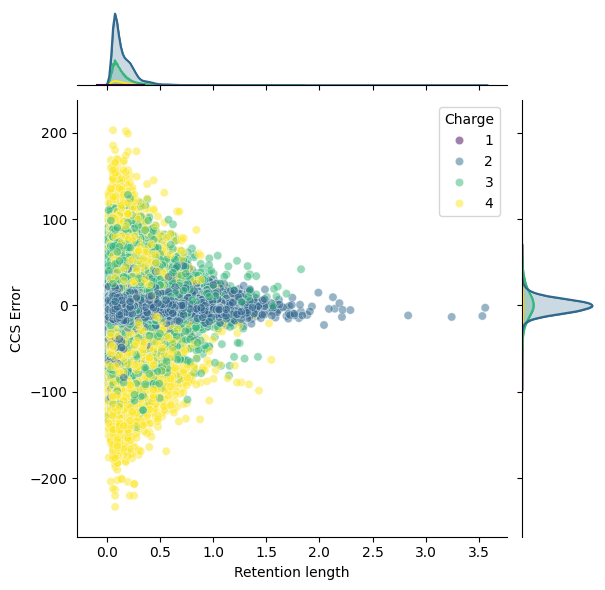

In [7]:
# scatter/kde: rt length vs ccs_Diff,(after TL)
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Retention length', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Retention length')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


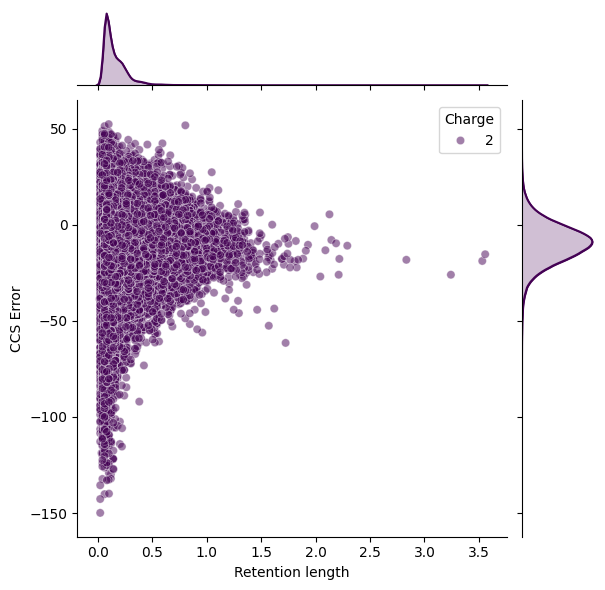

In [5]:
# scatter/kde: rt length vs ccs_Diff, color charge only charge 2
#sns.set(style="white", palette="viridis")
df_2 = df_comp[df_comp['Charge']==2]
g = sns.jointplot(data=df_2, x='Retention length', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Retention length')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


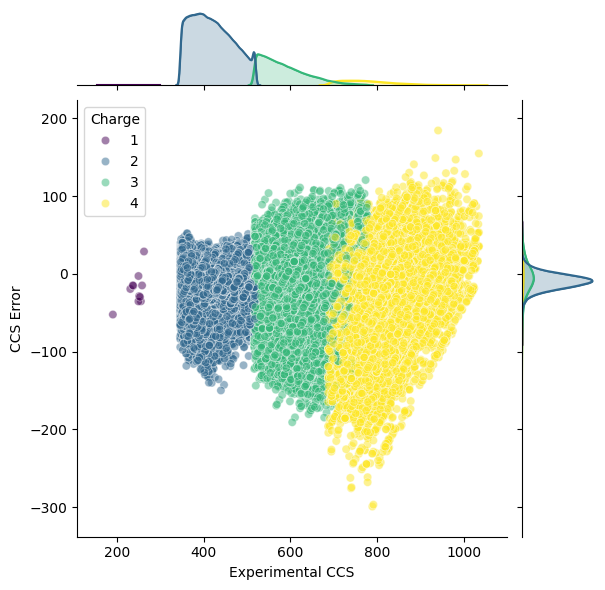

In [8]:
# scatter/kde: ccs vs ccs_Diff
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='CCS', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Experimental CCS')
plt.ylabel('CCS Error')
plt.show()

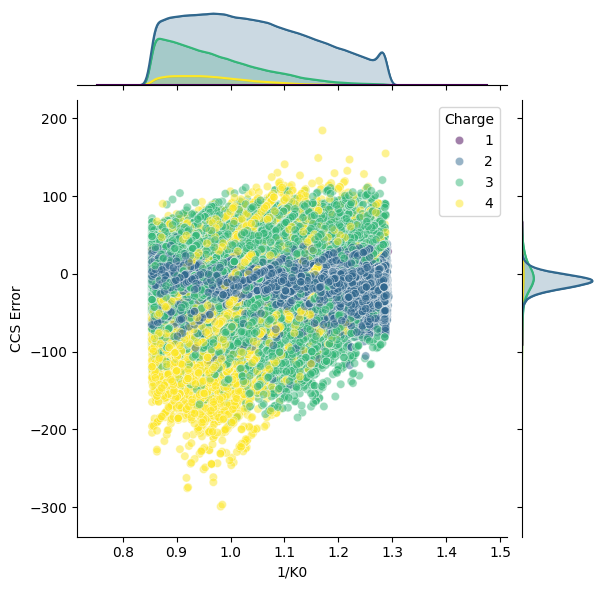

In [7]:
# scatter/kde: 1/K0 vs ccs_Diff, color charge
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='1/K0', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('1/K0')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


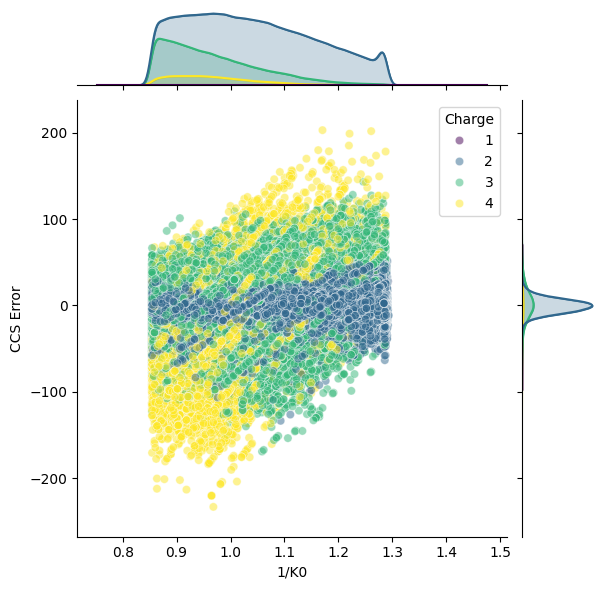

In [5]:
# scatter/kde: 1/K0 vs ccs_Diff, after TL
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='1/K0', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('1/K0')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


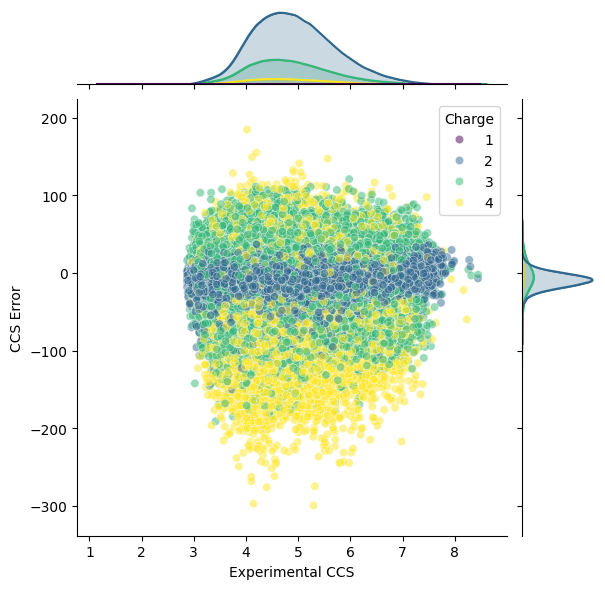

In [9]:
# scatter/kde: intensity vs ccs_Diff
#sns.set(style="white", palette="viridis")
df_comp['log_int'] = np.log10(df_comp['Intensity'])
g = sns.jointplot(data=df_comp, x='log_int', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Experimental CCS')
plt.ylabel('CCS Error')
plt.show()

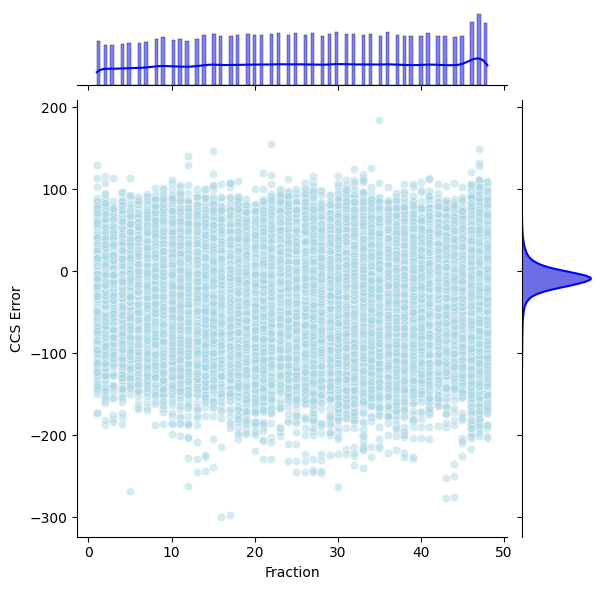

In [9]:
# scatter/kde fractions vs ccs_Diff
sns.jointplot(
    data=df_comp,
    x='Fraction',
    y='ccs_diff',
    kind='scatter',
    joint_kws={'color': 'lightblue', 'alpha': 0.5},
    marginal_kws={'color': 'blue', 'kde': True}
)
plt.xlabel('Fraction')
plt.ylabel('CCS Error')
plt.show()

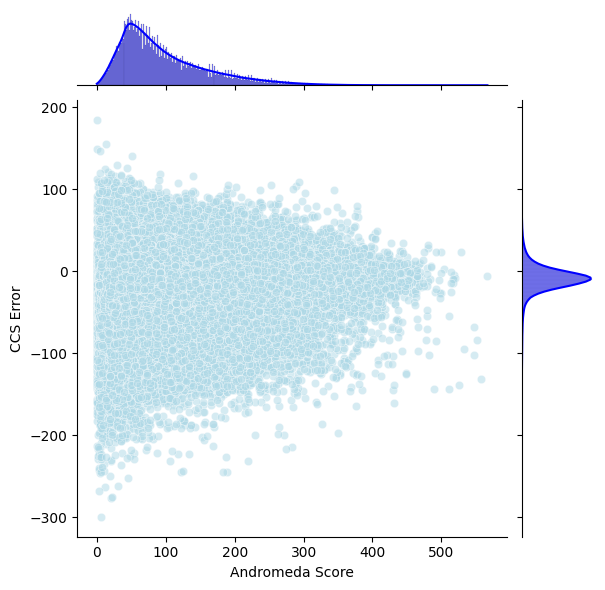

In [20]:
# scatter/kde: score vs ccs_Diff
sns.jointplot(
    data=df_comp,
    x='Score',
    y='ccs_diff',
    kind='scatter',
    joint_kws={'color': 'lightblue', 'alpha': 0.5},
    marginal_kws={'color': 'blue', 'kde': True}
)
plt.xlabel('Andromeda Score')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


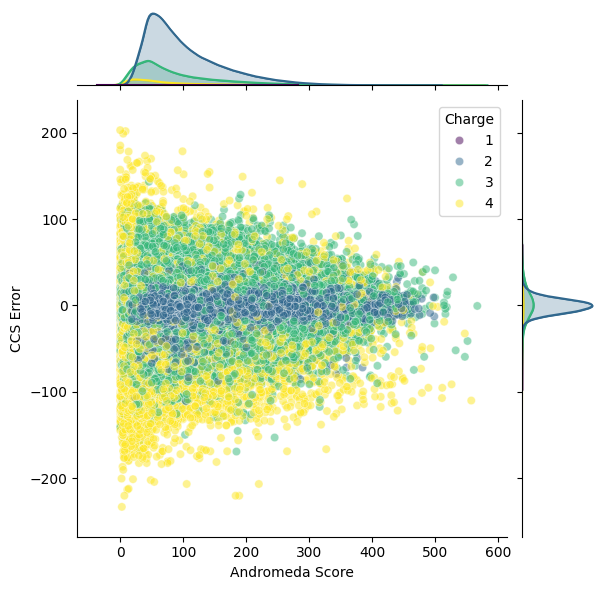

In [6]:
# scatter/kde: score vs ccs_Diff(after TL)
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Score', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Andromeda Score')
plt.ylabel('CCS Error')
plt.show()

c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


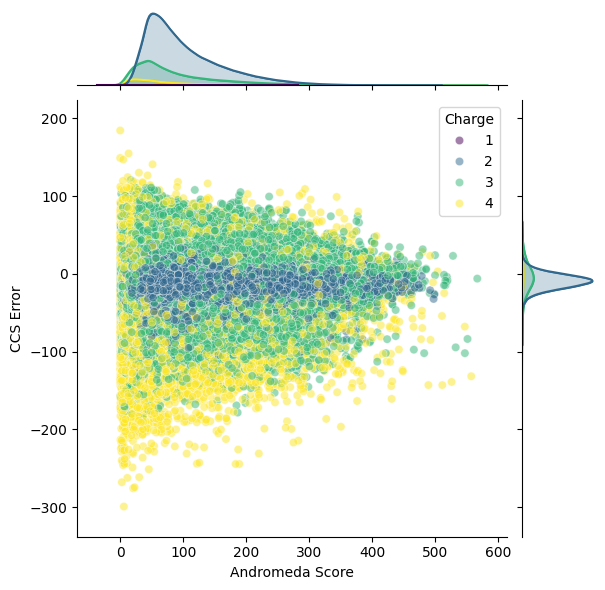

In [11]:
# scatter/kde: ccs vs ccs_Diff
#sns.set(style="white", palette="viridis")
g = sns.jointplot(data=df_comp, x='Score', y='ccs_diff', hue='Charge', kind="scatter", palette='viridis', alpha = 0.5)

# Add KDE plots on the marginal axes
g.plot_marginals(sns.kdeplot, common_norm=True)

plt.xlabel('Andromeda Score')
plt.ylabel('CCS Error')
plt.show()

### Error Bar Plot

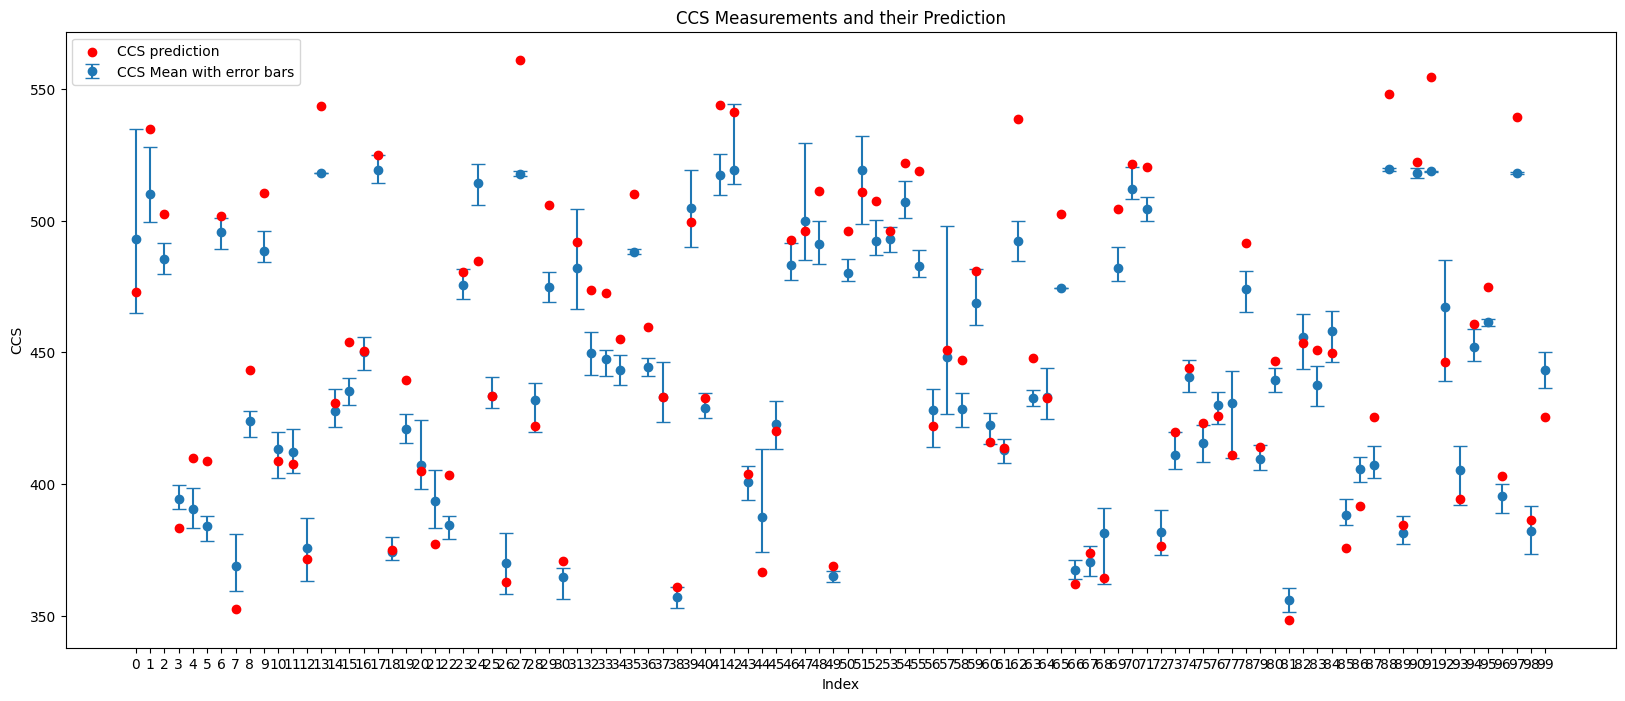

In [ ]:
#error bar plot
# Number of rows
df = mes_comp[0:100]
x = np.arange(len(df))

# Calculate the error
yerr = [df['ccs_max'] - df['ccs_mean'], df['ccs_mean'] - df['ccs_min']]

plt.figure(figsize=(20, 8))

# Plot error bars
plt.errorbar(x, df['ccs_max'], yerr=yerr, fmt='o', label='CCS Mean with error bars', capsize=5)

# Plot additional points
plt.scatter(x, df['ccs_pred_mean'], color='red', label='CCS prediction', zorder=5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('CCS')
plt.title('CCS Measurements and their Prediction')
plt.xticks(x, x)  # Set x-ticks to the index values
plt.legend()

# Show the plot
plt.show()

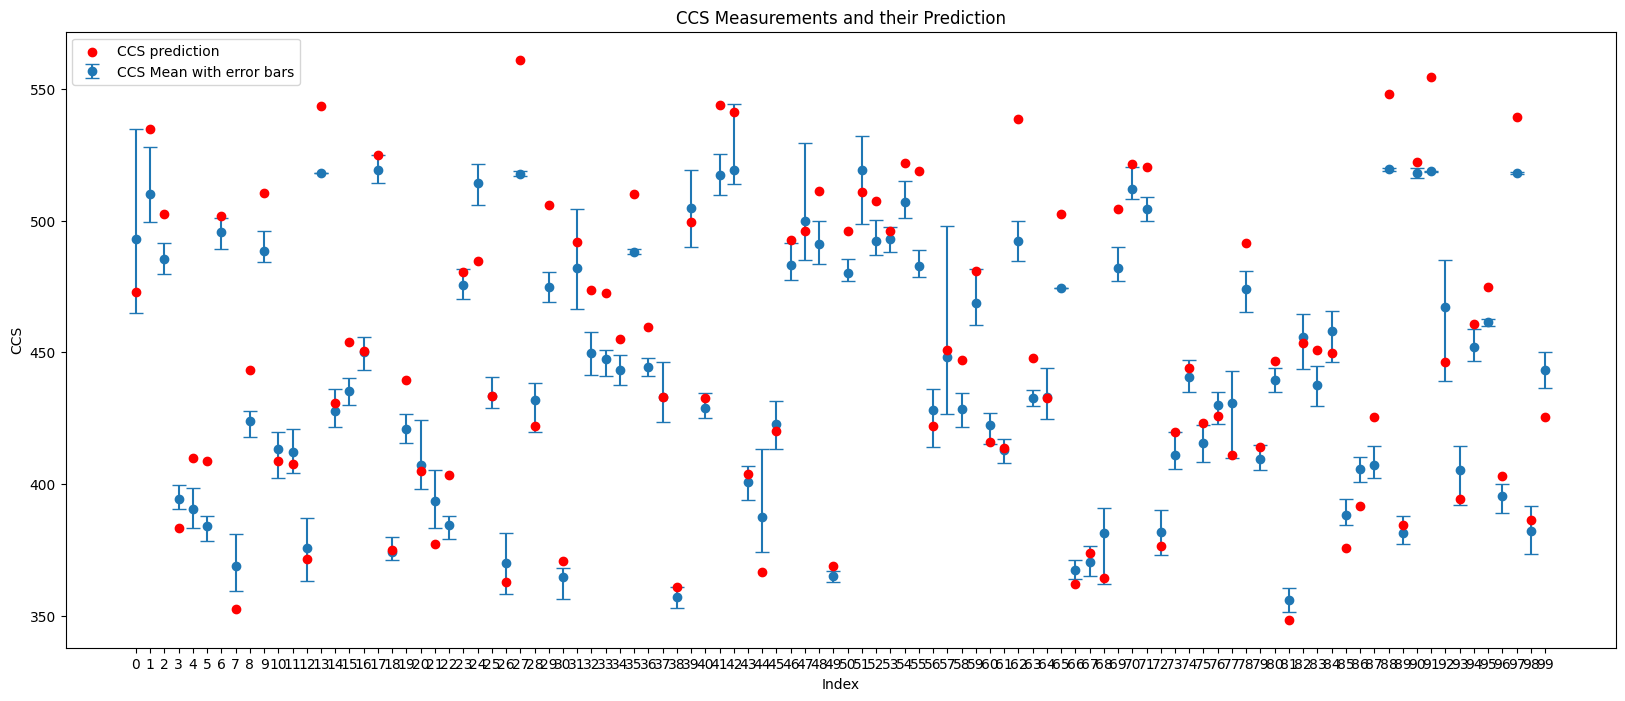

In [ ]:
plt.figure(figsize=(8, 4))

# Iterate over each row and plot the window as a line segment
for index, row in df.iterrows():
    plt.plot([row['lower'], row['upper']], [index, index], marker='o', label=f'Row {index+1}')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Row')
plt.title('Windows from DataFrame')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Violin Plots

2024-08-13 11:12:39> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_11716\2118696814.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',


2024-08-13 11:12:41> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


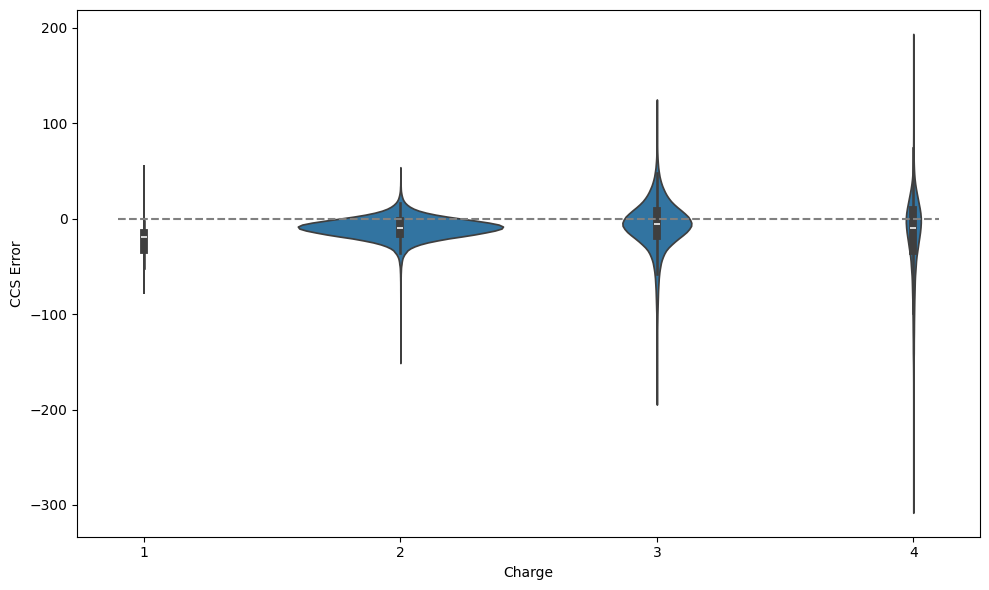

CCS:
-19.907441750149946
21.053373325340225
-9.713800277397713
11.031383135301944
-6.314423735283688
25.464557816207577
-17.160969218174678
41.56627520083667
IM:
-0.09813307937397112
0.1036504468410016
-0.0240582193702047
0.02731831361367727
-0.01046266386045565
0.0421462111976201
-0.021339920459858462
0.05167870041429205


: 

In [19]:
# violin plot: charge vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',

# Set plot labels and title
plt.xlabel('Charge')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.1, xmax= 3.1, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()
print('CCS:')
print(df_comp[df_comp['Charge']==1]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==1]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].std())
print('IM:')
print(df_comp[df_comp['Charge']==1]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==1]['IM_diff'].std())
print(df_comp[df_comp['Charge']==2]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==2]['IM_diff'].std())
print(df_comp[df_comp['Charge']==3]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==3]['IM_diff'].std())
print(df_comp[df_comp['Charge']==4]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==4]['IM_diff'].std())

2024-08-19 09:10:18> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_28976\1045654575.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',


2024-08-19 09:10:20> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


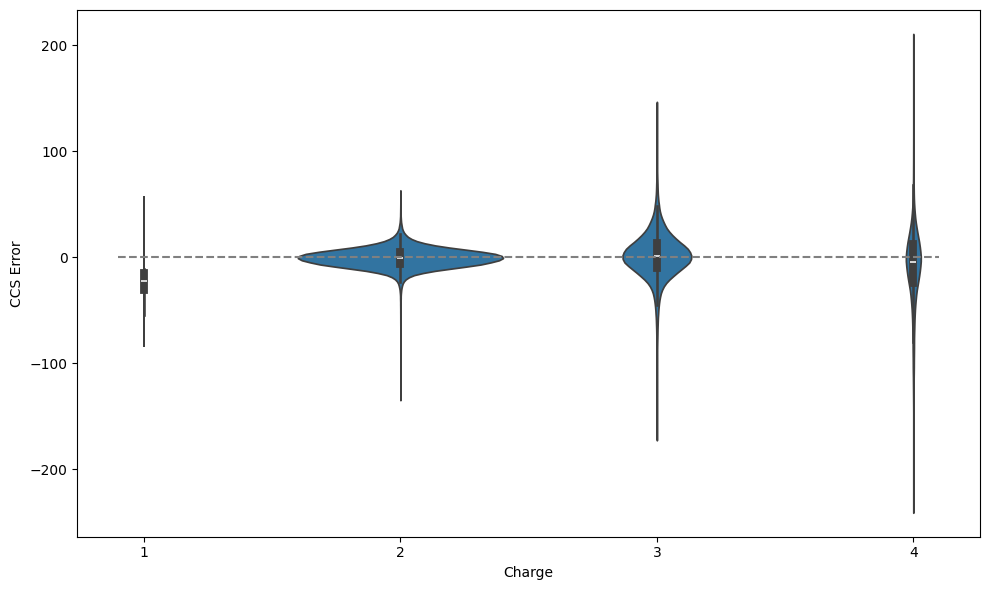

-18.47795677589568
23.38846456888066
-0.5722722997252624
9.215717614004701
1.3996714590923534
21.698354171537577
-8.494049919769735
36.20566668101252
-0.0910778745900075
0.11514100924604097
-0.0014181745655785665
0.02280740913285745
0.002309505411030826
0.03590912598583802
-0.010559054356673089
0.045010653167660286


In [4]:
# violin plot: charge vs CCS error(should beafter TL)
plt.figure(figsize=(10, 6))
sns.violinplot(x='Charge', y='ccs_diff', data=df_comp, scale='count')#inner='box',

# Set plot labels and title
plt.xlabel('Charge')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.1, xmax= 3.1, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()
print(df_comp[df_comp['Charge']==1]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==1]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==2]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==3]['ccs_diff'].std())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].mean())
print(df_comp[df_comp['Charge']==4]['ccs_diff'].std())

print(df_comp[df_comp['Charge']==1]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==1]['IM_diff'].std())
print(df_comp[df_comp['Charge']==2]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==2]['IM_diff'].std())
print(df_comp[df_comp['Charge']==3]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==3]['IM_diff'].std())
print(df_comp[df_comp['Charge']==4]['IM_diff'].mean())
print(df_comp[df_comp['Charge']==4]['IM_diff'].std())

2024-07-18 11:24:22> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_11220\2236113424.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp, scale='count', width=1.0)


2024-07-18 11:24:24> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


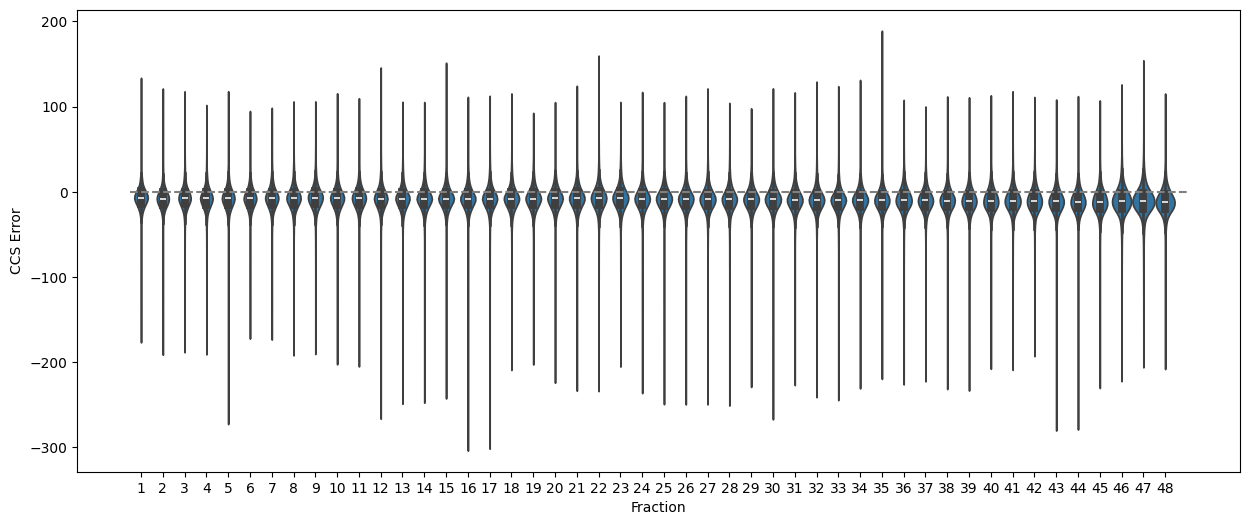

In [60]:
# violin plot: fractions vs CCS error
plt.figure(figsize=(15, 6))
sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp, scale='count', width=1.0)

# Set plot labels and title
plt.xlabel('Fraction')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 48, linestyles='--', colors='grey')

# Display the plot
plt.show()

2024-07-18 13:53:30> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_22344\3568896187.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Length', y='ccs_diff', data=df_comp, scale='count', width=0.9)


2024-07-18 13:53:32> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


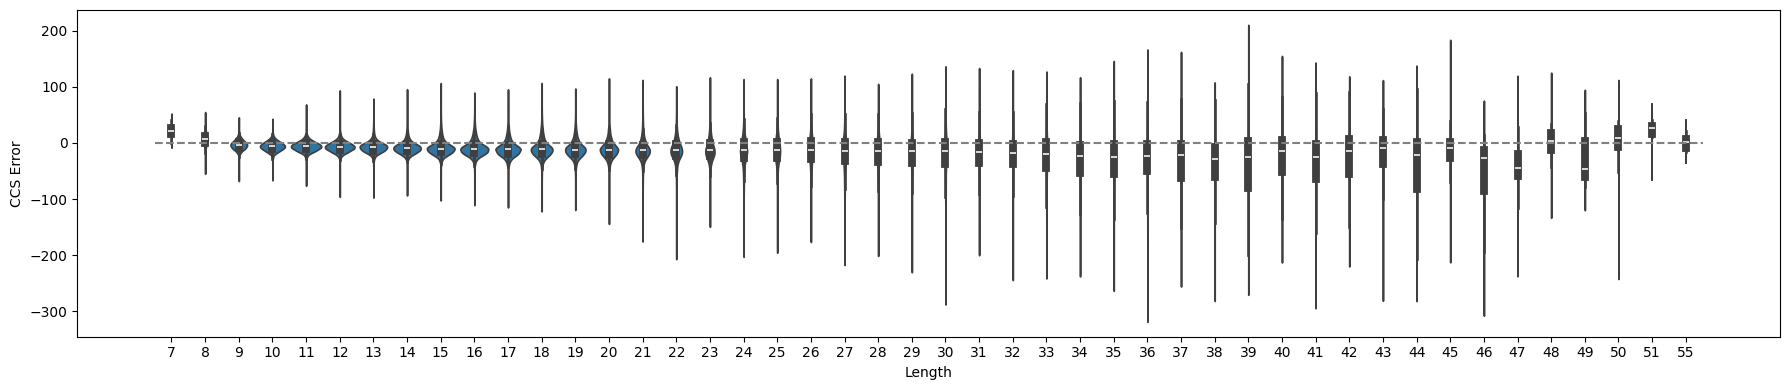

In [9]:
# violin plot: Length vs CCS error
plt.figure(figsize=(18, 4))
sns.violinplot(x='Length', y='ccs_diff', data=df_comp, scale='count', width=0.9)

# Set plot labels and title
plt.xlabel('Length')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 45.5, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()

2024-07-22 10:50:44> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-22 10:50:45> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


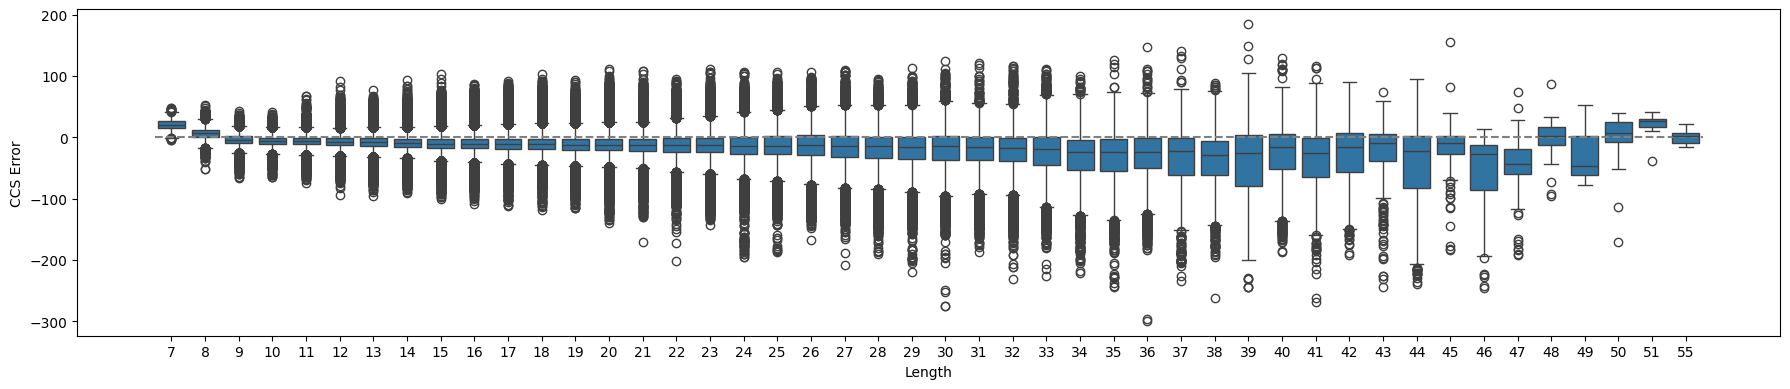

In [6]:
# box plot: Length vs CCS error
plt.figure(figsize=(18, 4))
sns.boxplot(x='Length', y='ccs_diff', data=df_comp)

# Set plot labels and title
plt.xlabel('Length')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 45.5, linestyles='--', colors='grey')
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\cocob\AppData\Local\Temp\ipykernel_11220\1563121614.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Modifications', y='ccs_diff', data=df_comp, scale='count', width=1.2)


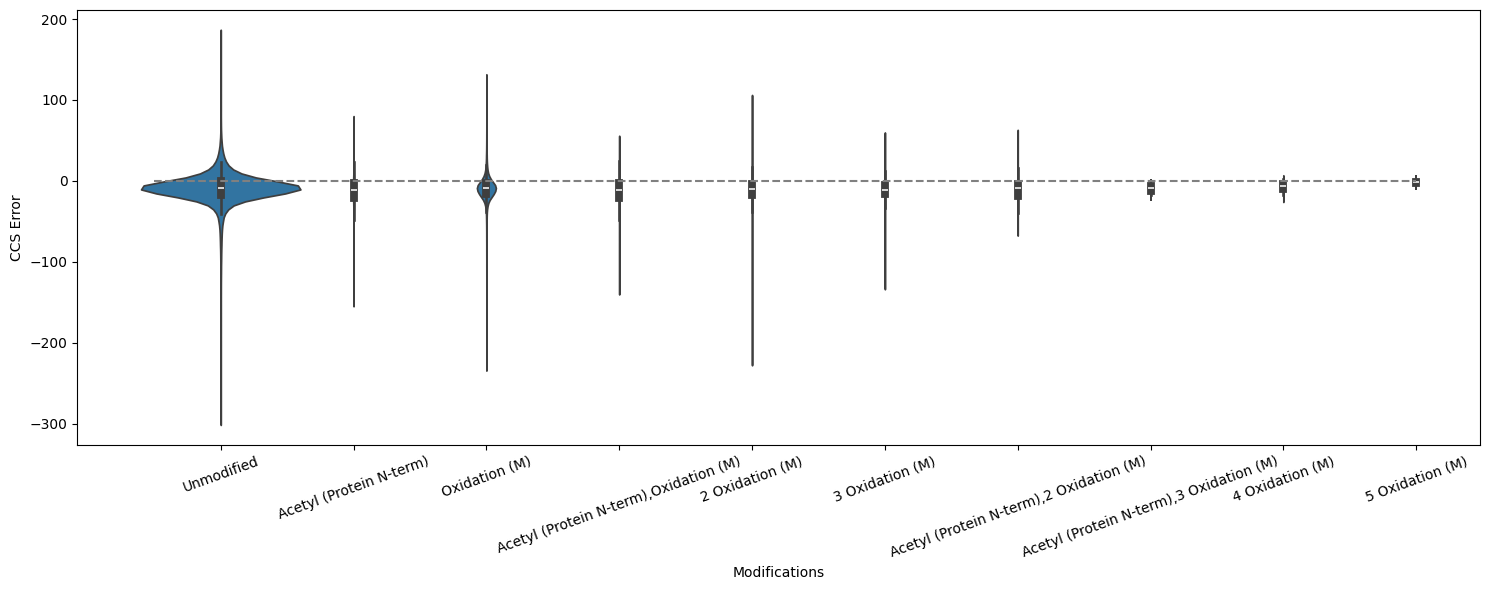

In [70]:
# violin plot: moodifications vs CCS error
plt.figure(figsize=(15, 6))
sns.violinplot(x='Modifications', y='ccs_diff', data=df_comp, scale='count', width=1.2)

# Set plot labels and title
plt.xlabel('Modifications')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 9, linestyles='--', colors='grey')
plt.xticks(rotation = 20)
plt.tight_layout()
# Display the plot
plt.show()

In [9]:
for mod in df_comp['Modifications'].unique():
    df_mod = df_comp[df_comp['Modifications']==mod]
    print(f"{mod}:{df_mod['ccs_diff'].mean()}, {df_mod['IM_diff'].mean()}")

Unmodified:-0.5699027294729836, -0.001143394748637401
Acetyl (Protein N-term):-0.7313158365944883, -0.0014458758471858418
Oxidation (M):-0.06433020017514914, 5.7483685099275465e-05
Acetyl (Protein N-term),Oxidation (M):0.37801814707510617, 0.0012118683424140956
2 Oxidation (M):-0.023140107378428185, 0.00027121826737298556
3 Oxidation (M):1.4695942939932833, 0.00303378529892893
Acetyl (Protein N-term),2 Oxidation (M):-0.8484104468714188, -0.00024664139105108656
Acetyl (Protein N-term),3 Oxidation (M):6.975156047537688, 0.017303377141231008
4 Oxidation (M):3.2479529022420373, 0.008055194788117247
5 Oxidation (M):7.471415226614113, 0.018535585637615926


C:\Users\cocob\AppData\Local\Temp\ipykernel_22344\2193791786.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Experiment', y='IM_diff', data=df_comp, scale='count')


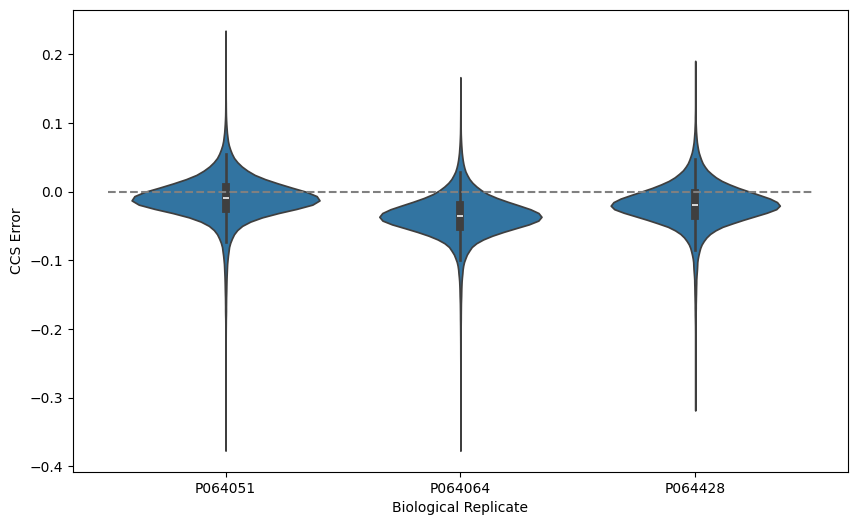

In [13]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='IM_diff', data=df_comp, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()

## Check Prediction Accuracy for peptides measured multiple times

In [31]:
# create grouped df for sequences with multiple measurements (['charge', 'sequence', 'mods', 'mod_sites'])

# drop groups with only one peptide
mes = df_comp.groupby(['charge', 'sequence', 'mods', 'mod_sites']).filter(lambda x: len(x)>2)
mes_comp = mes.groupby(['charge', 'sequence', 'mods', 'mod_sites']).agg({
    'ccs': ['mean','min','max'],
    'ccs_pred': 'mean',
    'mobility': ['mean','min','max'],
    'mobility_pred':'mean'
}, axis = 1).reset_index()
mes_comp.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in mes_comp.columns]
mes_comp = mes_comp.drop_duplicates()

In [34]:
mes_comp['ccs_diff'] = mes_comp['ccs_max']- mes_comp['ccs_min']
mes_comp['IM_diff'] = mes_comp['mobility_max']- mes_comp['mobility_min']
mes_comp['ccs_diff_mean'] = mes_comp['ccs_max']-mes_comp['ccs']

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyError: ''

In [7]:
print(df_comp['ccs_diff'].mean())
print(df_comp['IM_diff'].mean())

-9.287576317477447
-0.020677852599147582


## Difference of Prediction to Mean

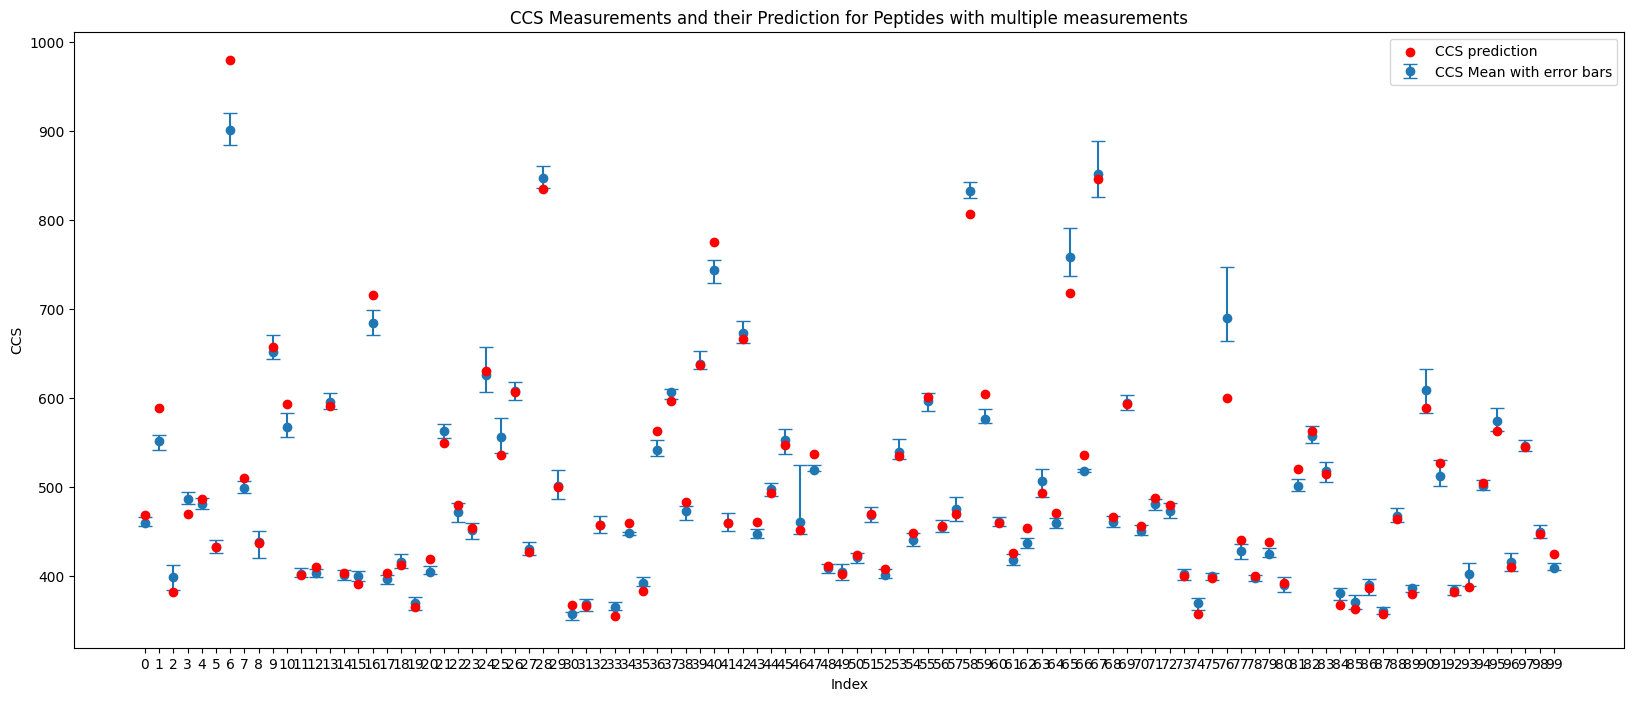

In [45]:
# error bar plot: Difference of Prediction to Mean
# Random sampling to 100 rows
df_sample = mes_comp.sample(n = 100, random_state=42)
x = np.arange(len(df_sample))

# Calculate the error
yerr = [df_sample['ccs_max'] - df_sample['ccs_mean'], df_sample['ccs_mean'] - df_sample['ccs_min']]

plt.figure(figsize=(20, 8))

# Plot error bars
plt.errorbar(x, df_sample['ccs_max'], yerr=yerr, fmt='o', label='CCS Mean with error bars', capsize=5)

# Plot additional points
plt.scatter(x, df_sample['ccs_pred_mean'], color='red', label='CCS prediction', zorder=5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('CCS')
plt.title('CCS Measurements and their Prediction for Peptides with multiple measurements')
plt.xticks(x, x)  # Set x-ticks to the index values
plt.legend()

# Show the plot
plt.show()

In [5]:
# calculate the mean difference of Prediction to Mean for every number of measurements
# check if the prediction will be closer to mean if multiple measurements
for i in range(2,15):
    mes = df_comp.groupby(['charge', 'sequence', 'mods', 'mod_sites']).filter(lambda x: len(x)==i)
    mes_comp = mes.groupby(['charge', 'sequence', 'mods', 'mod_sites']).agg({
        'ccs': ['mean','min','max'],
        'ccs_pred': 'mean',
        'mobility': ['mean','min','max'],
        'mobility_pred':'mean'
    }, axis = 1).reset_index()
    mes_comp.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in mes_comp.columns]
    mes_comp = mes_comp.drop_duplicates()
    print(f'For {i} Measurements:\t {len(mes_comp)},\t {(mes_comp['ccs_mean']-mes_comp['ccs_pred_mean']).abs().mean()}')

For 2 Measurements:	 15000,	 16.428056099519434
For 3 Measurements:	 10688,	 15.603769064890999
For 4 Measurements:	 8390,	 14.900245344560792
For 5 Measurements:	 6521,	 14.704294743372097
For 6 Measurements:	 5237,	 14.041255803395632
For 7 Measurements:	 3644,	 14.439140941883837
For 8 Measurements:	 2705,	 13.857568671426803
For 9 Measurements:	 1944,	 14.026725958869244
For 10 Measurements:	 1590,	 13.538747193245523
For 11 Measurements:	 1136,	 14.363563241882071
For 12 Measurements:	 925,	 13.550364040302378
For 13 Measurements:	 745,	 13.559755040273307
For 14 Measurements:	 629,	 14.43847042374614


In [12]:
# check peptides where CCS Difference is > window
df_big = df_comp[df_comp['ccs_diff'].abs()>window]
print(len(df_big))
df_big_unique = df_big.drop_duplicates(subset=['sequence', 'charge', 'mods', 'mod_sites'])
print(len(df_big_unique))
# check scores, intensity, length, charge

15122
5041


C:\Users\cocob\AppData\Local\Temp\ipykernel_29312\2826289084.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(group[x], group[y], label=category, alpha = 0.7, cmap='viridis')


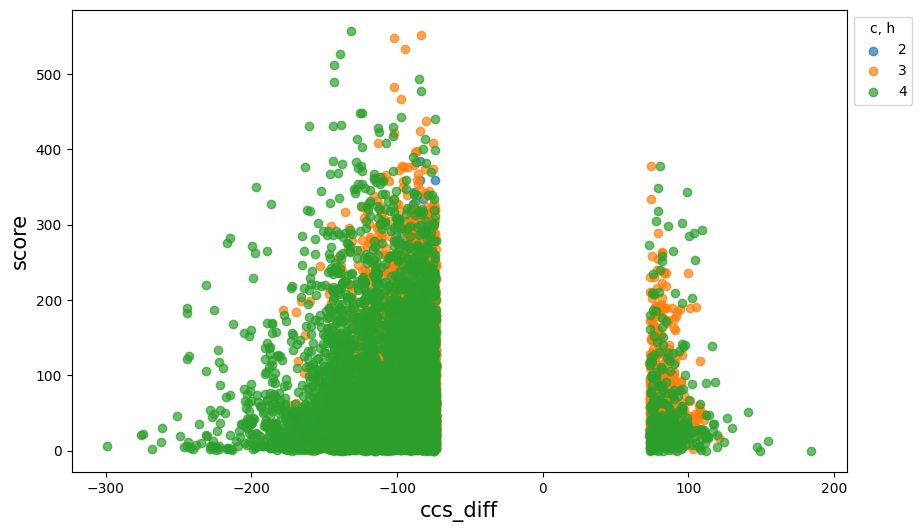

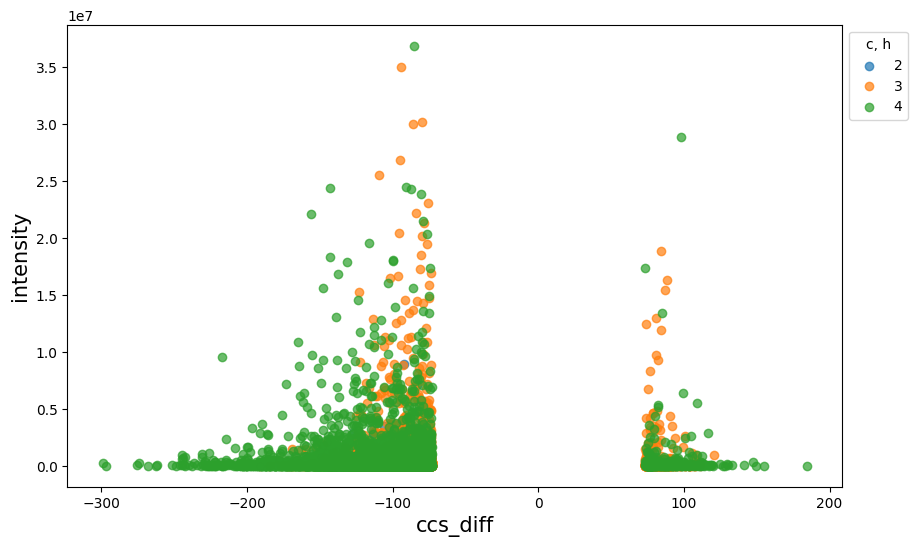

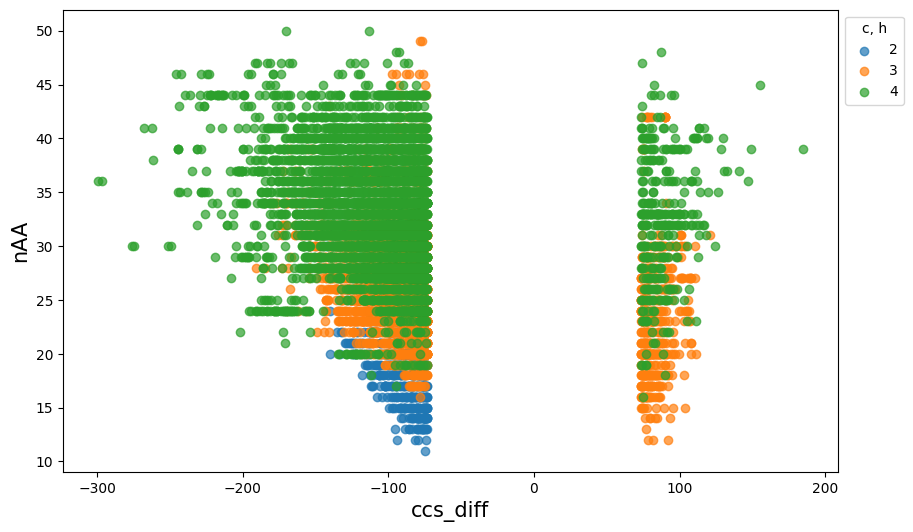

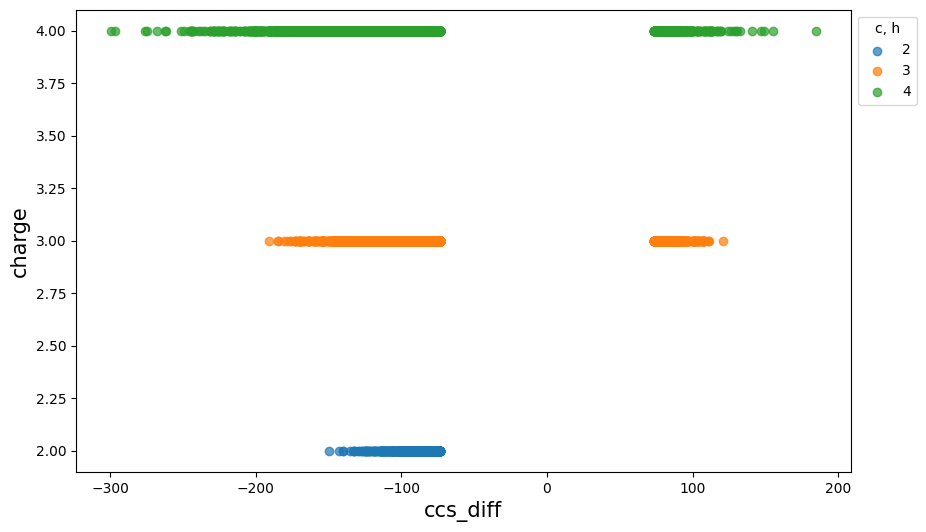

: 

In [19]:
# check scores, intensity, length, charge of df_big
%run methods_freshfrozen.ipynb
plot_scatter(df_big, x = 'ccs_diff', y = 'score', c = 'charge')
plot_scatter(df_big, x = 'ccs_diff', y = 'intensity', c = 'charge')
plot_scatter(df_big, x = 'ccs_diff', y = 'nAA', c = 'charge')
plot_scatter(df_big, x = 'ccs_diff', y = 'charge', c = 'charge')

## Percentiles

In [6]:
# percentile of CCS Difference
df_all = pd.read_csv('comparisons/comp_all.txt', sep='\t')
perc_low = np.percentile(df_all['ccs_diff'], 2.5)
perc_up = np.percentile(df_all['ccs_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-47.34994989470609, 25.93828768255638)


In [7]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

73.28823757726246


In [14]:
# percentile of CCS Difference
#df_all = pd.read_csv('comparisons/comp_all.txt', sep='\t')
perc_low = np.percentile(df_all['IM_diff'], 2.5)
perc_up = np.percentile(df_all['IM_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-0.08992281480531564, 0.04507234789204871)


In [15]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

0.13499516269736433


In [40]:
print(f'CCS range: {df_all['ccs_pred'].min()}, {df_all['ccs_pred'].max()}')
print(df_all['ccs_pred'].max()-df_all['ccs_pred'].min())
print(((perc_low)*(-1)+perc_up)/(df_all['ccs_pred'].max()-df_all['ccs_pred'].min()))

CCS range: 233.56124877929688, 1088.2490234375
854.6877746582031
0.08574855023118945


In [42]:
print(30/1.8)
print(1.8/30)

16.666666666666668
0.060000000000000005


In [5]:
# trying the formualr from statsig docs
ci= np.add(df_comp['ccs_diff'], 1.96*(df_comp['ccs_diff'].var()**0.5))
print(ci)

0          51.571527
1          51.571528
2           1.605074
3          -0.209243
4          49.773181
             ...    
1396563    18.311444
1396564    18.911657
1396565    26.558591
1396566    25.357245
1396567    43.645822
Name: ccs_diff, Length: 1396568, dtype: float64


In [24]:
# calculate percentiles per hand
n = len(df_comp)
p = (2.5/100)*n
print(p)
p = round(p)
print(p)
df_order = df_comp['ccs_diff'].sort_values( ascending=True, ignore_index=True)
print(df_order[p])

34914.200000000004
34914
-47.350000054668044


In [26]:
# calculate percentiles per hand
n = len(df_comp)
p = (97.5/100)*n
print(p)
p = round(p)
print(p)
df_order = df_comp['ccs_diff'].sort_values( ascending=True, ignore_index=True)
print(df_order[p])

1361653.8
1361654
25.938306075741025


## R^2

In [6]:
r = sk.r2_score(y_true = df_comp['CCS'], y_pred = df_comp['ccs_pred'])
print(r)

0.9653029187986866


In [ ]:
r = sk.r2_score(y_true = df_comp['1/K0'], y_pred = df_comp['mobility_pred'])
print(r)

0.8807574652819061


In [4]:
#after TL
r = sk.r2_score(y_true = df_comp['CCS'], y_pred = df_comp['ccs_pred'])
print(r)

0.9798814369164778


In [5]:
#after TL
r = sk.r2_score(y_true = df_comp['1/K0'], y_pred = df_comp['mobility_pred'])
print(r)

0.9393084386145228


# Check for raw file bias

In [10]:
# split df into the 3 Experiments
df = df_comp
df_51 = df[df["Experiment"]=='P064051']
df_64 = df[df["Experiment"]=='P064064']
df_28 = df[df["Experiment"]=='P064428']

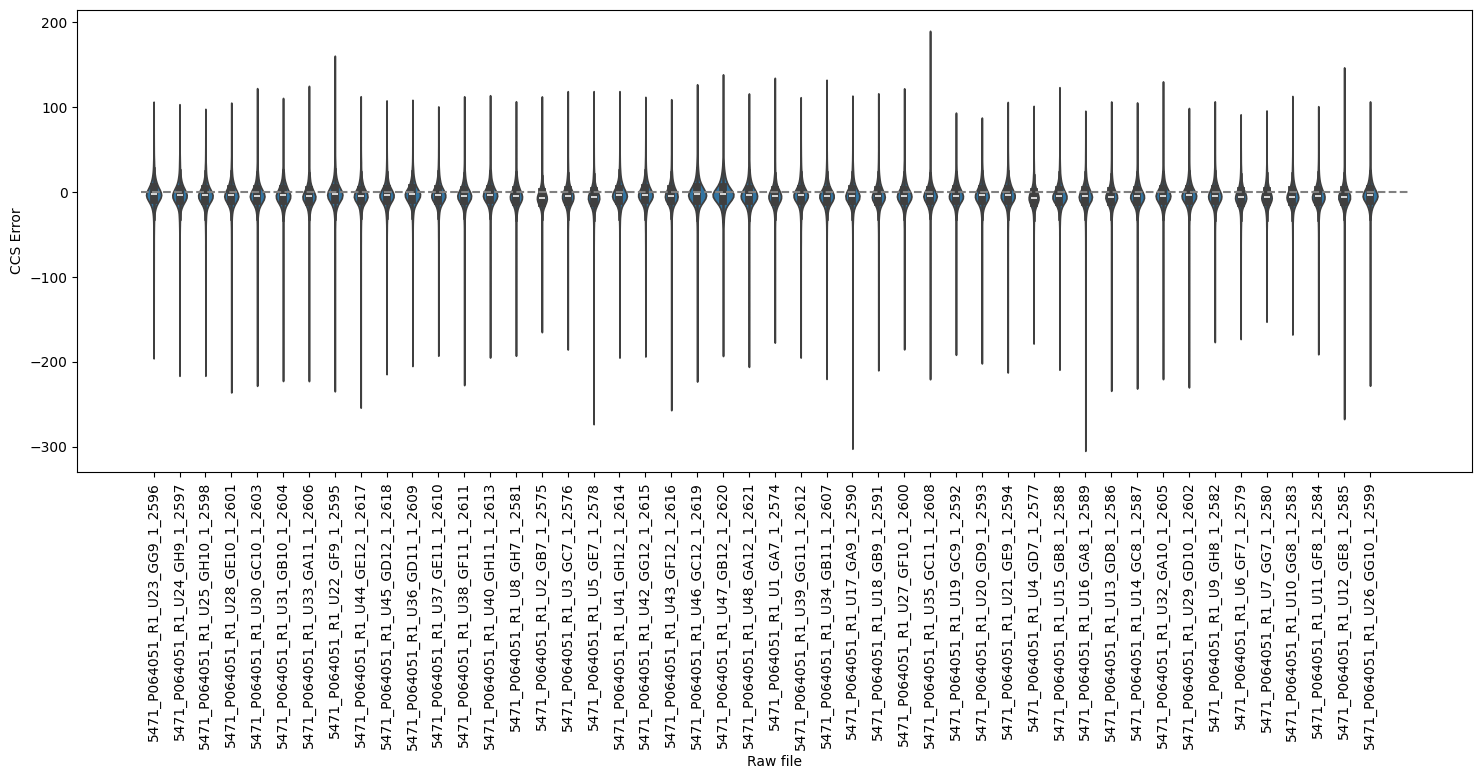

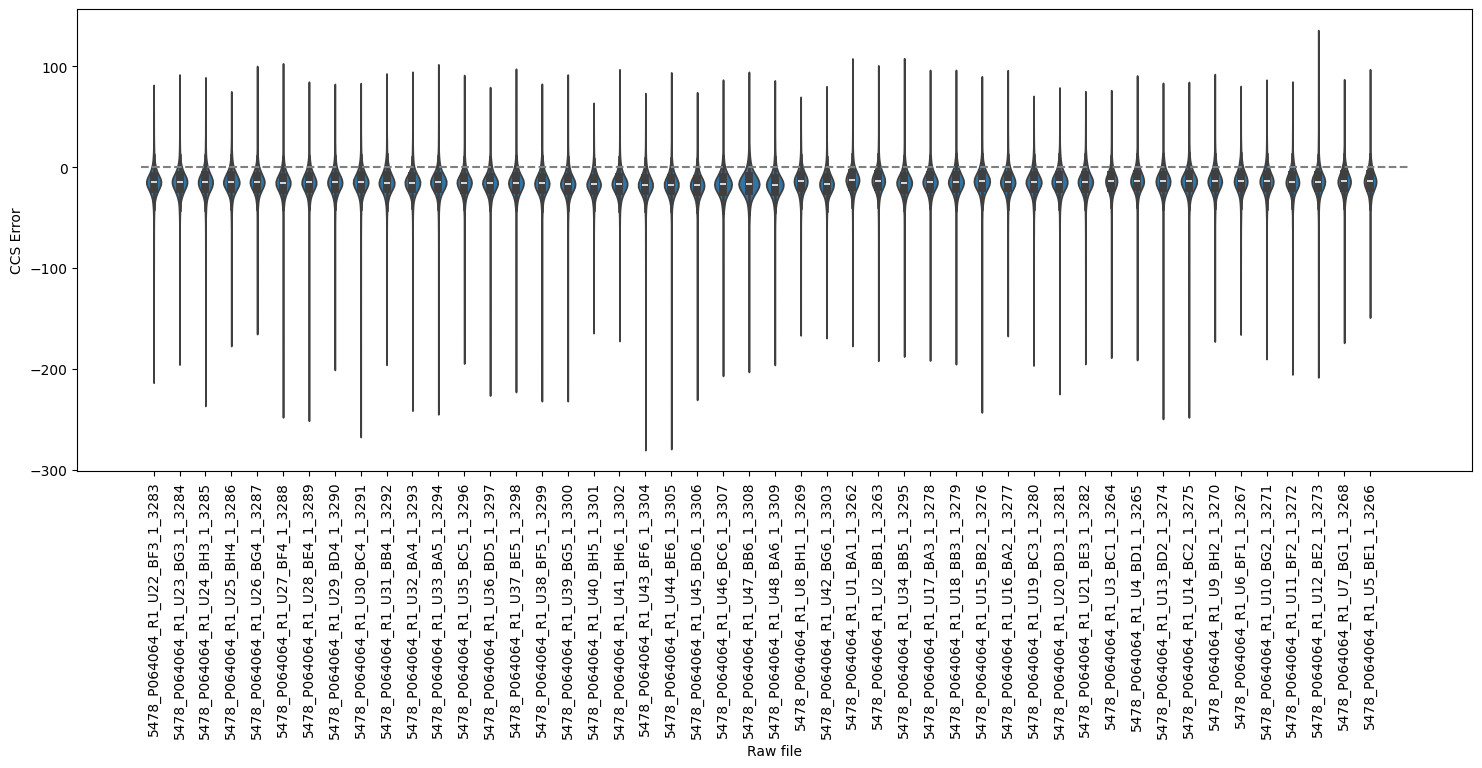

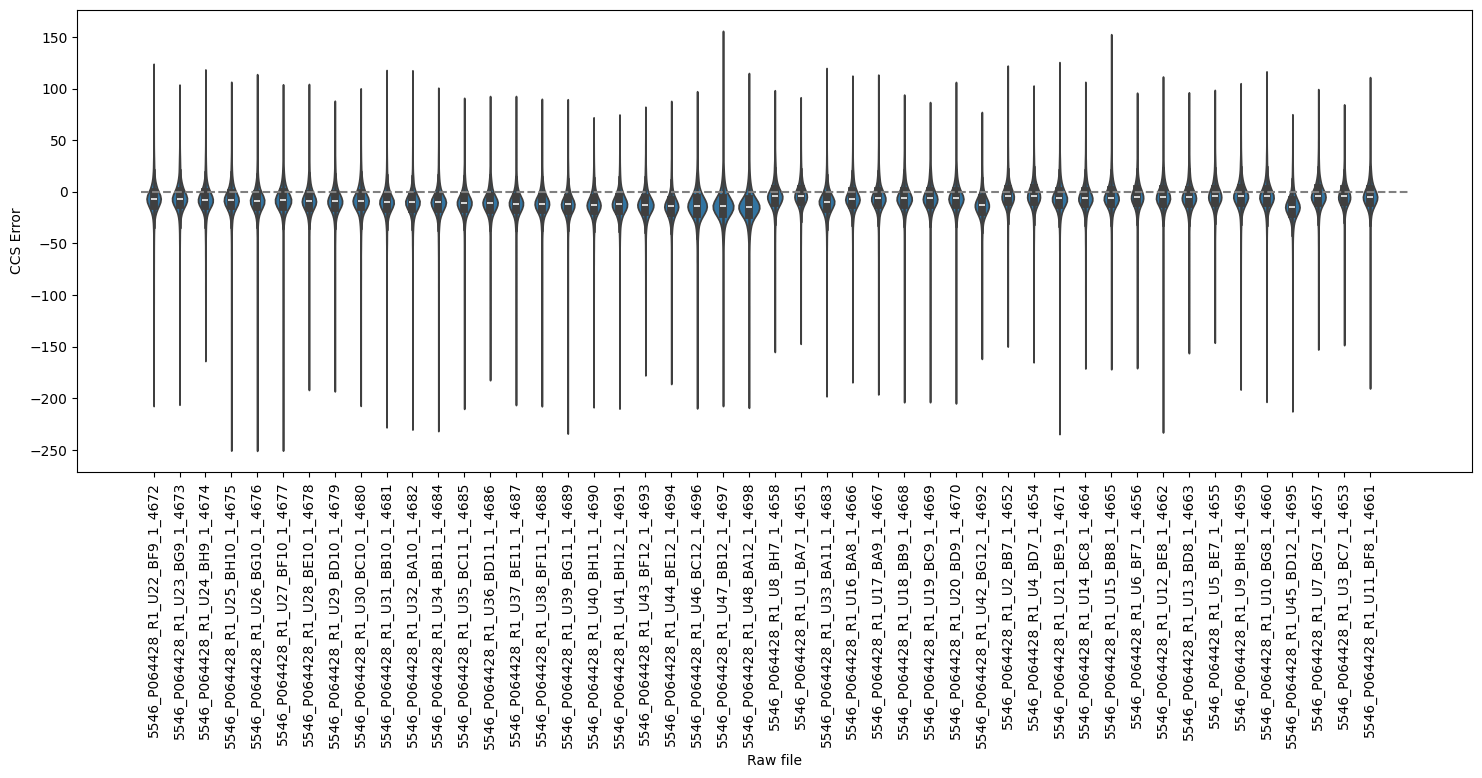

In [17]:
list_df = [df_51, df_64, df_28]
list_exp = ['P064051', 'P064064', 'P064428']
for df in list_df:
    plt.figure(figsize=(18, 6))
    sns.violinplot(x='Raw file', y='ccs_diff', data=df, density_norm='count')

    # Set plot labels and title
    plt.xlabel('Raw file')
    plt.ylabel('CCS Error')
    #print(list_df.index(df))
    #plt.title(f"{list_exp[list_df.index(df)]}")
    plt.xticks(rotation = 90)
    plt.hlines(y = 0.0, xmin = -0.5, xmax= 48.5, linestyles='--', colors='grey')

2024-07-29 17:08:51> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-29 17:08:52> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-29 17:08:54> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-29 17:08:55> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-29 17:08:57> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

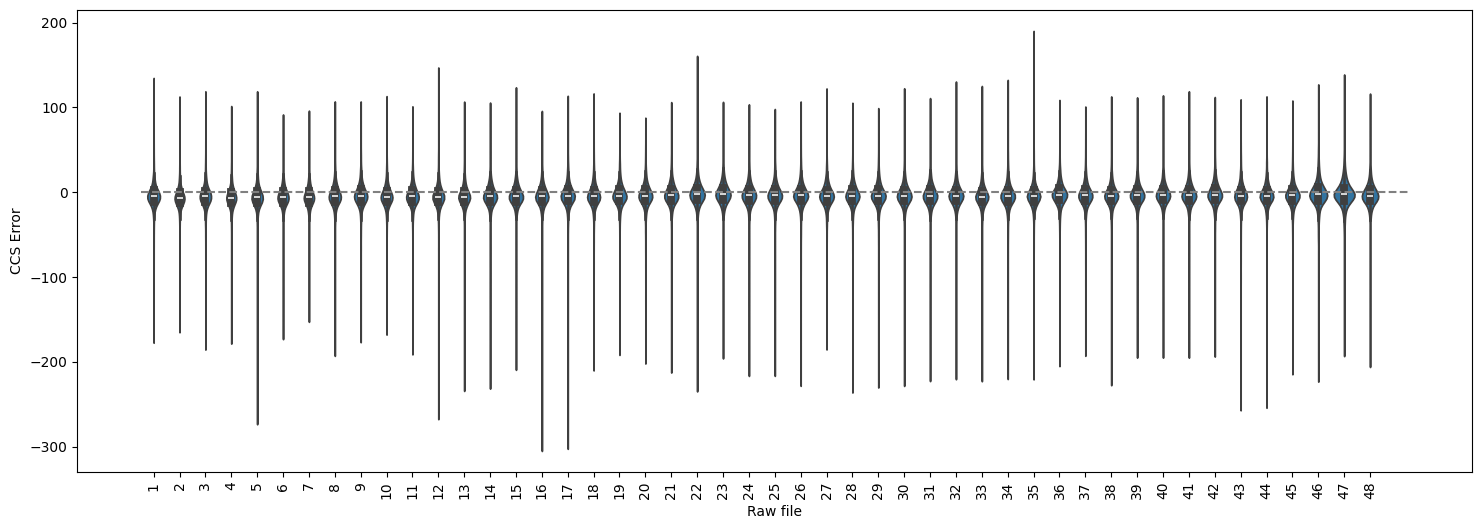

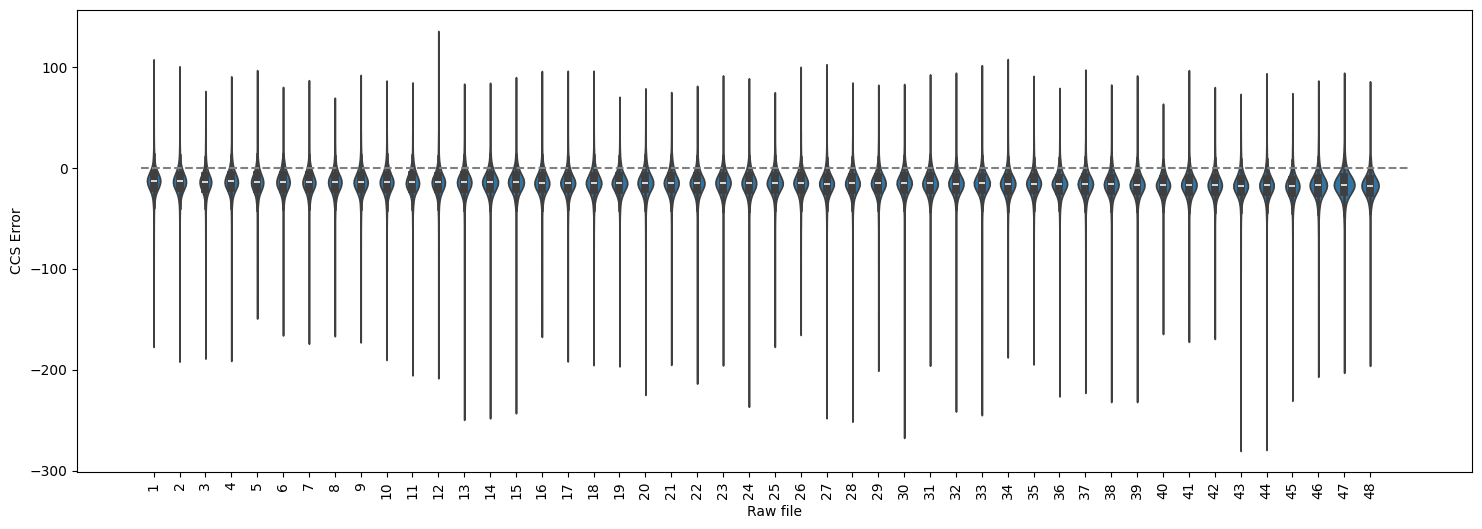

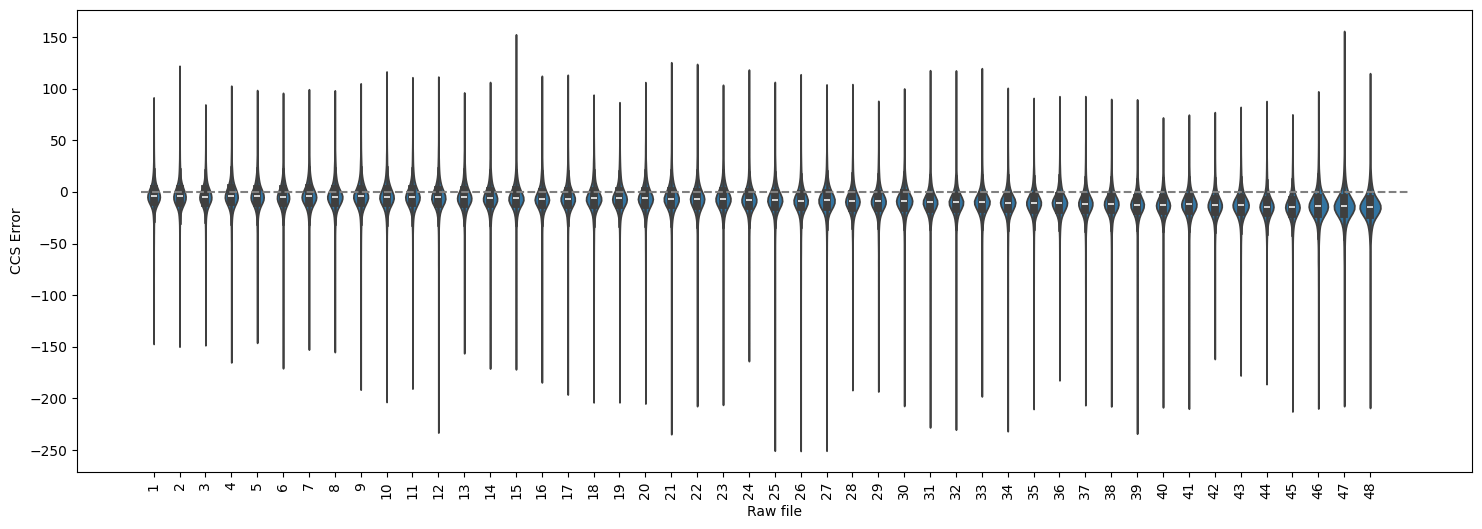

In [18]:
list_df = [df_51, df_64, df_28]
list_exp = ['P064051', 'P064064', 'P064428']
for df in list_df:
    plt.figure(figsize=(18, 6))
    sns.violinplot(x='Fraction', y='ccs_diff', data=df, density_norm='count')

    # Set plot labels and title
    plt.xlabel('Raw file')
    plt.ylabel('CCS Error')
    #print(list_df.index(df))
    #plt.title(f"{list_exp[list_df.index(df)]}")
    plt.xticks(rotation = 90)
    plt.hlines(y = 0.0, xmin = -0.5, xmax= 48.5, linestyles='--', colors='grey')

# Modifications

TODO: run this section
See if the results are worth mentioning, if the negative change in the oxidation is predicted correctly 

In [7]:
def difference_mass_modification2(df: pd.DataFrame, modification: str, property: str, threshhold=1000):
    df_mod = df[df['Modifications'] == modification]
    df_mod = df_mod.dropna(subset=[property])

    if len(df_mod)>threshhold:
        #print(f'Dataframe({modification}) has length {len(df_mod)}, {threshhold} sequences are randomly sampled for further analysis')
        df_mod = df_mod.sample(n = threshhold, random_state=42)
    
    # Create a new DataFrame to store results
    length_df_before = len(df_mod)

    # create dataframe with sequence-> mean of property over sequence
    df_unmodified = df[(df['Sequence'].isin(df_mod['Sequence'].tolist())&(df['Modifications']=='Unmodified'))][['Sequence',property]]
    grouped_avg = df_unmodified.groupby('Sequence')[property].mean()
    grouped_avg_df = grouped_avg.reset_index()

    # make difference column
    merged_df = pd.merge(df_mod, grouped_avg_df[['Sequence', property]], on='Sequence', suffixes=('_mod', '_unmod'), how='inner')

    # Calculate difference and add as a new column in df1
    merged_df['Difference'] = merged_df[f'{property}_mod'] - merged_df[f'{property}_unmod']   

    return merged_df

In [ ]:
df_comp = pd.read_csv('comparisons/comp_orig.txt', sep = '\t')

In [9]:
#%run methods_freshfrozen.ipynb
# sample size = 10000
df_list = ['df_un', 'df_ac', 'df_ac_ox', 'df_ac_2ox', 'df_ac_3ox', 'df_ox','df_ox2', 'df_ox3', 'df_ox4', 'df_ox5']
str_list = ['Unmodified', 'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),Oxidation (M)', 'Acetyl (Protein N-term),2 Oxidation (M)', 'Acetyl (Protein N-term),3 Oxidation (M)', 'Oxidation (M)',
            '2 Oxidation (M)', '3 Oxidation (M)', '4 Oxidation (M)', '5 Oxidation (M)']
prop_list = [ '1/K0']
diff = 'Difference'
for prop in prop_list:
    print(f'Difference in {prop}')
    counter = 0
    for df_diff in df_list:
        df_diff = difference_mass_modification2(df_comp, str_list[counter], prop)
        print(f'{str_list[counter]}: {df_diff[diff].mean()}, {df_diff[diff].std()}')
        counter +=1
    print()


Difference in 1/K0
Unmodified: -0.0025654504211134826, 0.05497841832613929
Acetyl (Protein N-term): 0.04393575452595057, 0.07350318421476015
Acetyl (Protein N-term),Oxidation (M): 0.04327549989117761, 0.06230625978436694
Acetyl (Protein N-term),2 Oxidation (M): 0.1140361167951974, 0.09624804830924352
Acetyl (Protein N-term),3 Oxidation (M): 0.19964930776728101, 0.01722719785643032
Oxidation (M): -0.0024676794526579415, 0.05621614090281844
2 Oxidation (M): -0.0081871713511892, 0.05074635442545451
3 Oxidation (M): -0.00861765551553207, 0.05268490266247811
4 Oxidation (M): -0.012591006640271844, 0.016272420566413825
5 Oxidation (M): -0.022991680256234437, 0.007670811312286194



In [10]:
#%run methods_freshfrozen.ipynb
# sample size = 10000
df_list = ['df_un', 'df_ac', 'df_ac_ox', 'df_ac_2ox', 'df_ac_3ox', 'df_ox','df_ox2', 'df_ox3', 'df_ox4', 'df_ox5']
str_list = ['Unmodified', 'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),Oxidation (M)', 'Acetyl (Protein N-term),2 Oxidation (M)', 'Acetyl (Protein N-term),3 Oxidation (M)', 'Oxidation (M)',
            '2 Oxidation (M)', '3 Oxidation (M)', '4 Oxidation (M)', '5 Oxidation (M)']
prop_list = [ 'mobility_pred']
diff = 'Difference'
for prop in prop_list:
    print(f'Difference in {prop}')
    counter = 0
    for df_diff in df_list:
        df_diff = difference_mass_modification2(df_comp, str_list[counter], prop)
        print(f'{str_list[counter]}: {df_diff[diff].mean()}, {df_diff[diff].std()}')
        counter +=1
    print()


Difference in mobility_pred
Unmodified: -0.003324963421106524, 0.059435350996607315
Acetyl (Protein N-term): 0.05720877977241957, 0.07720680588710864
Acetyl (Protein N-term),Oxidation (M): 0.054569469862458156, 0.07190226469283317
Acetyl (Protein N-term),2 Oxidation (M): 0.13955623281162513, 0.1101301772088773
Acetyl (Protein N-term),3 Oxidation (M): 0.2580433026777569, 0.0029734068699679614
Oxidation (M): -0.004268331946226922, 0.05964471998841264
2 Oxidation (M): -0.012751069113776634, 0.05256502336711861
3 Oxidation (M): -0.011451276463118429, 0.0603344850940966
4 Oxidation (M): -0.011287748904575215, 0.005776115695042171
5 Oxidation (M): -0.016515831922251145, 0.0



# Linear Regression CCS

### Train

In [13]:
# sample df to 
n = 10000
df_comp_train = df_comp.sample(n=n, random_state=42)

In [15]:
linear_reg = sk_lm.LinearRegression()
linear_reg.fit(y = df_comp_train['ccs'].values.reshape(-1,1), X = df_comp_train['ccs_pred'].values.reshape(-1,1))
intercept = linear_reg.intercept_[0]
slope = linear_reg.coef_[0][0]

# Adjusted predictions
df_comp_train['ccs_adj'] = intercept + slope * df_comp_train['ccs_pred']

In [16]:
print(intercept)
print(slope)

8.494072575000246
0.9634287374964938


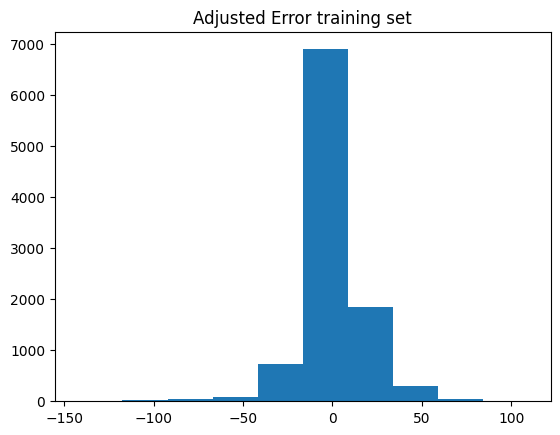

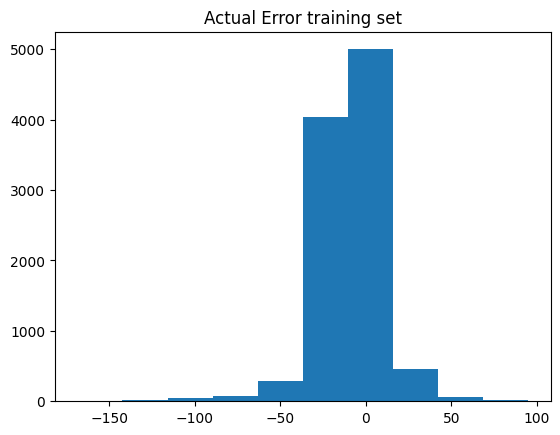

In [18]:
df_comp_train['adj_diff'] = np.subtract(df_comp_train['ccs'].values, df_comp_train['ccs_adj'].values)
plt.hist(df_comp_train['adj_diff'])
plt.title('Adjusted Error training set')
plt.show()
plt.hist(df_comp_train['ccs_diff'])
plt.title('Actual Error training set')
plt.show()

### Test

In [23]:
# test set
# get the part of df which is not in training set
merged_df = df_comp.merge(df_comp_train, left_index=True, right_index=True, how='left', indicator=True)
df_comp_test = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge', 'ccs_y', 'ccs_pred_y', 'ccs_diff_y'])
df_comp_test.rename(columns={'ccs_x': 'CCS', 'ccs_pred_x':'ccs_pred', 'ccs_diff_x':'ccs_diff'}, inplace=True)

# sample for test set
df_comp_test = df_comp_test.sample(n = 10000)
print(len(df_comp_test))

KeyError: "['ccs_y'] not found in axis"

In [24]:
# test set
df_comp_test = df_comp.drop(df_comp_train.index)
# sample for test set
df_comp_test = df_comp_test.sample(n = 10000)

In [ ]:
df_comp_test['ccs_adj'] = intercept + slope * df_comp_test['ccs_pred']

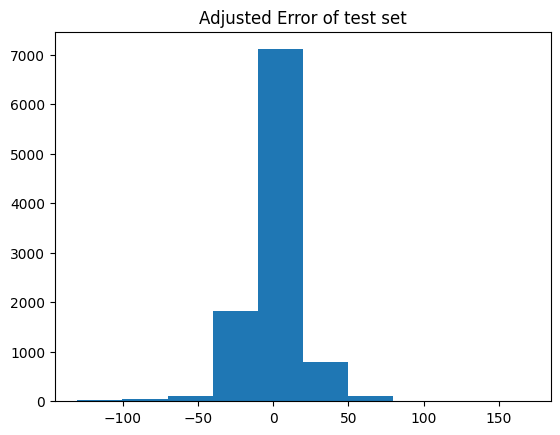

In [89]:
df_comp_test['adj_diff'] = np.subtract(df_comp_test['ccs'].values, df_comp_test['ccs_adj'].values)
plt.hist(df_comp_test['adj_diff'])
plt.title('Adjusted Error of test set')
plt.show()

In [87]:
print(df_comp_test['ccs_diff'].mean())
print(df_comp_test['adj_diff'].mean())

-9.329835838823007
0.007159789573542702


### Complete Dataset

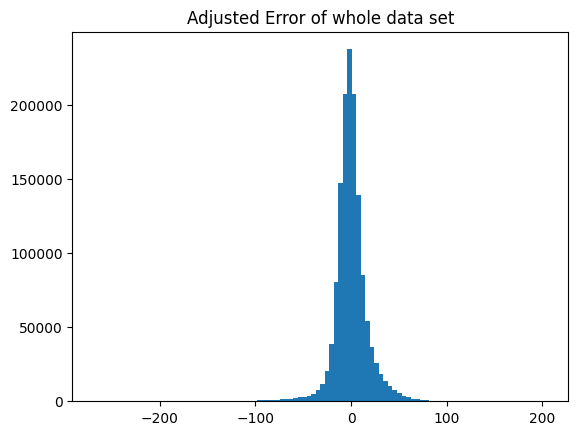

In [19]:
df_comp['ccs_adj'] = intercept + slope * df_comp['ccs_pred']
df_comp['adj_diff'] = np.subtract(df_comp['ccs'].values, df_comp['ccs_adj'].values)
plt.hist(df_comp['adj_diff'], bins=100)
plt.title('Adjusted Error of whole data set')
plt.show()


In [20]:
print(df_comp['adj_diff'].mean())
print(df_comp['adj_diff'].std())

0.03941407126168249
17.796924337852005


### Percentiles on adjusted Dataset

In [21]:
perc_low = np.percentile(df_comp['adj_diff'], 2.5)
perc_up = np.percentile(df_comp['adj_diff'], 97.5)
print(f'({perc_low}, {perc_up})')

(-32.83003824038933, 39.01964539471093)


In [22]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

71.84968363510026


## Linear Regression IM

### Train

In [49]:
# get input for prediction
# use AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
#mq_reader.fixed_C57 = False # This line excludes all the Carboi... Modifications at C's
df_mods = mq_reader.import_file("evidence_freshfrozen_base.txt")

In [27]:
# sample df to 
n = 10000
df_mods_train = df_comp.sample(n=n, random_state=42)

In [28]:
linear_reg = sk_lm.LinearRegression()
linear_reg.fit(y = df_mods_train['mobility'].values.reshape(-1,1), X = df_mods_train['mobility_pred'].values.reshape(-1,1))
intercept = linear_reg.intercept_[0]
slope = linear_reg.coef_[0][0]

# Adjusted predictions
df_comp_train['mobility_adj'] = intercept + slope * df_comp_train['mobility_pred']

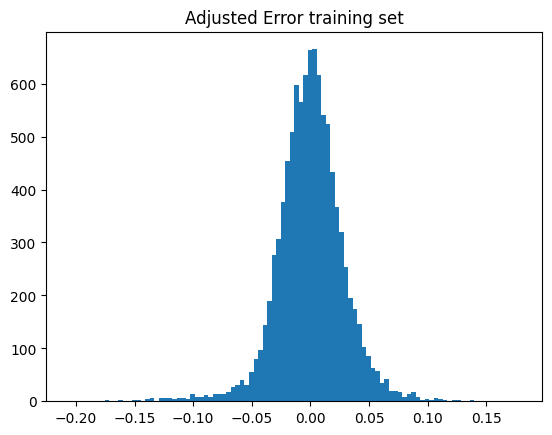

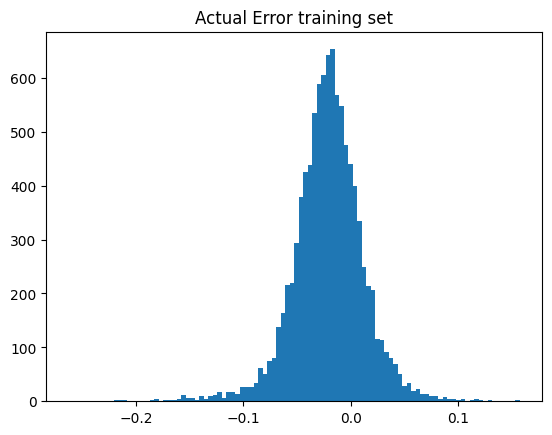

In [112]:
df_comp_train['adj_diff'] = np.subtract(df_comp_train['mobility'].values, df_comp_train['mobility_adj'].values)
plt.hist(df_comp_train['adj_diff'], bins=100)
plt.title('Adjusted Error training set')
plt.show()
plt.hist(df_comp_train['IM_diff'], bins =100)
plt.title('Actual Error training set')
plt.show()

In [105]:
print(df_comp_train['IM_diff'].mean())
print(df_comp_train['adj_diff'].mean())

-0.02099061234170992
-3.2467362132138077e-16


### Test

In [54]:
# test set
df_mods_test = df_mods.drop(df_mods_train.index)
# sample for test set
df_mods_test = df_mods_test.sample(n = 10000)

In [107]:
prediction_test = 

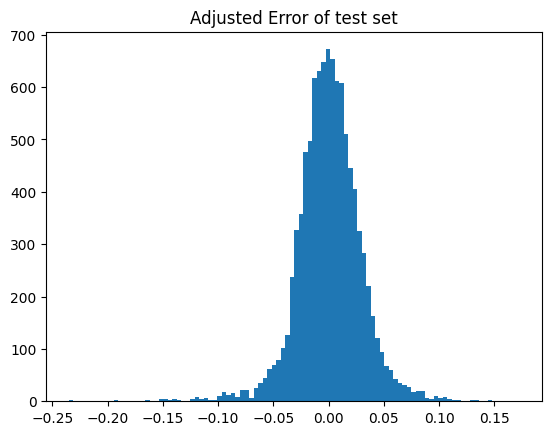

In [113]:
df_comp_test['adj_diff'] = np.subtract(df_comp_test['mobility'].values, df_comp_test['mobility_adj'].values)
plt.hist(df_comp_test['adj_diff'], bins = 100)
plt.title('Adjusted Error of test set')
plt.show()

In [109]:
print(df_comp_test['IM_diff'].mean())
print(df_comp_test['adj_diff'].mean())

-0.020226802337223085
0.0003094561146450813


### Complete Dataset

In [31]:
print(intercept)
print(slope)

0.11382908491701504
0.8707387411828236


In [3]:
intercept = 0.11382908491701504
slope = 0.8707387411828236

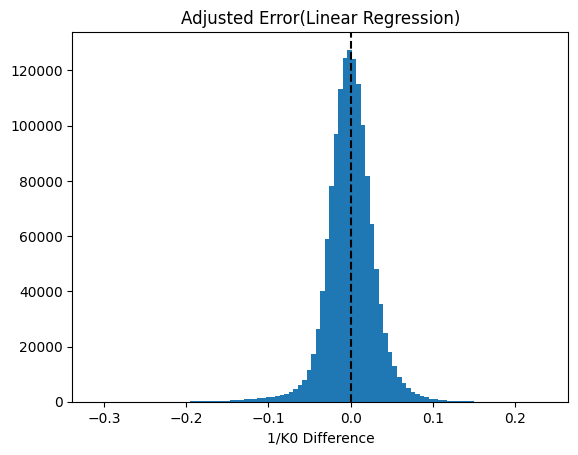

-0.00011309812201099498
0.029293656886356278


In [4]:
df_comp['mobility_adj'] = intercept + slope * df_comp['mobility_pred']
df_comp['adj_diff'] = np.subtract(df_comp['mobility'].values, df_comp['mobility_adj'].values)
plt.hist(df_comp['adj_diff'], bins=100)
plt.title('Adjusted Error(Linear Regression)')
plt.xlabel('1/K0 Difference')
plt.axvline(x = 0.0, linestyle = '--', c = 'black')
plt.show()
print(df_comp['adj_diff'].mean())
print(df_comp['adj_diff'].std())

### Percentiles

In [114]:
# percentile of CCS Difference
#df_all = pd.read_csv('comparisons/comp_all.txt', sep='\t')
perc_low = np.percentile(df_comp['adj_diff'], 2.5)
perc_up = np.percentile(df_comp['adj_diff'], 97.5)
print(f'({perc_low}, {perc_up})')

print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

(-0.05828948089360422, 0.0569624478451533)
0.11525192873875753


# Matrix Effect

## Compare Prediction to CCS of highest intensities

In [10]:
# filter the highest intensities
mes = df_comp.groupby(['charge', 'sequence', 'mods', 'mod_sites']).filter(lambda x: len(x)>3)
idx = mes.groupby(['charge', 'sequence', 'mods', 'mod_sites'])['intensity'].idxmax()
df_highest = df_comp.loc[idx].reset_index(drop=True)

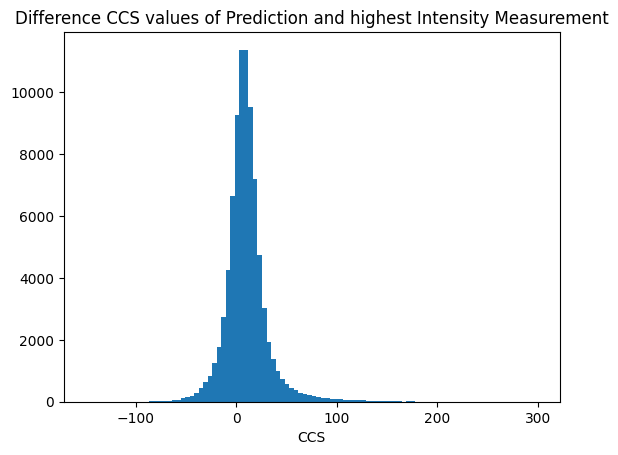

In [6]:
# plot Diff highest Intensities, Prediction
plt.hist((df_highest['ccs_pred'].abs()-df_highest['ccs'].abs()), bins = 100)
plt.xlabel('CCS')
plt.title(f'Difference CCS values of Prediction and highest Intensity Measurement')    
plt.show()

In [7]:
print((df_highest['ccs_pred'].abs()-df_highest['ccs'].abs()).mean())

10.249470871981183


In [11]:
mes_comp['ccs_highest_int'] = df_highest['ccs']

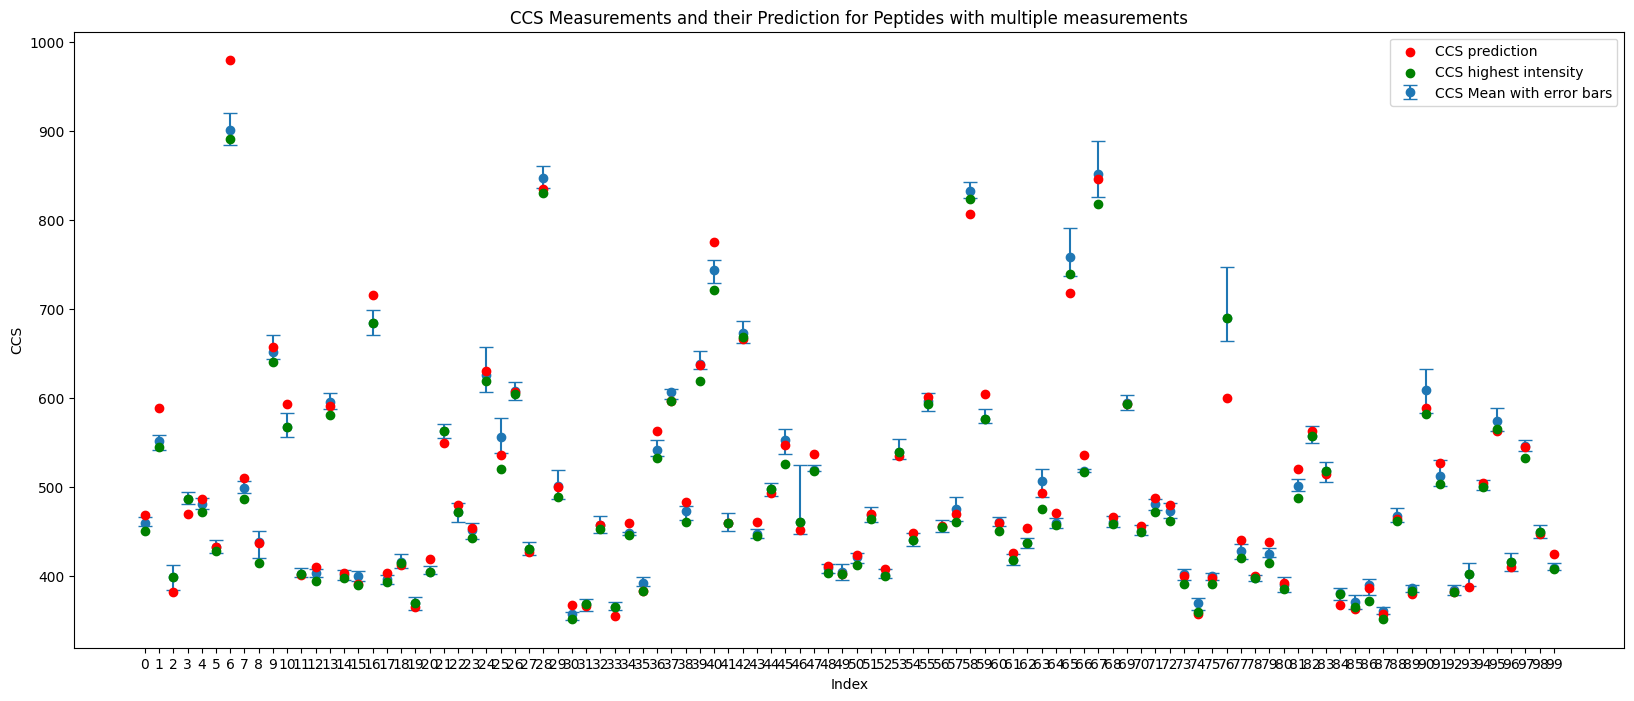

In [12]:
# error bar plot: Difference of Prediction to Mean
# Random sampling to 100 rows
df_sample = mes_comp.sample(n = 100, random_state=42)
x = np.arange(len(df_sample))

# Calculate the error
yerr = [df_sample['ccs_max'] - df_sample['ccs_mean'], df_sample['ccs_mean'] - df_sample['ccs_min']]

plt.figure(figsize=(20, 8))

# Plot error bars
plt.errorbar(x, df_sample['ccs_max'], yerr=yerr, fmt='o', label='CCS Mean with error bars', capsize=5)

# Plot additional points
plt.scatter(x, df_sample['ccs_pred_mean'], color='red', label='CCS prediction', zorder=5)
plt.scatter(x, df_sample['ccs_highest_int'], color = 'green', label='CCS highest intensity', zorder=5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('CCS')
plt.title('CCS Measurements and their Prediction for Peptides with multiple measurements')
plt.xticks(x, x)  # Set x-ticks to the index values
plt.legend()

# Show the plot
plt.show()

## Check for Fraction bias

TODO: check entire section(dry coded)

In [ ]:
procal_peptides = ['YSAHEEHHYDK', 'HEHISSDYAGK' , 'TFAHTESHISK' , 'ISLGEHEGGGK', 'FGTGTYAGGEK' , 'LSSGYDGTSYK', 'TASGVGGFSTK' , 'VGASTGYSGLK' , 'SYASDFGSSAK' , 'LYSYYSSTESK' ,
 'LYTGAGYDEVK' , 'TLIAYDDSSTK', 'FLASSEGGFTK' , 'FVGTEYDGLAK' , 'YALDSYSLSSK' , 'HLTGLTFDTYK' , 'GFLDYESTGAK' ,'HDTVFGSYLYK' , 'YFGYTSDTFGK' , 'ALFSSITDSEK' , 'HFALFSTDVTK' ,
'VSGFSDISIYK' , 'TFTGTTDSFFK' , 'TFGTETFDTFK' , 'ASDLLSGYYIK' , 'FLFTGYDTSVK' , 'VYAETLSGFIK' , 'TSIDSFIDSYK' , 'GFVIDDGLITK' , 'GIFGAFTDDYK' , 'GASDFLSFAVK' , 'VSSIFFDTFDK' ,
 'FFLTGTSIFVK' , 'GDFTFFIDTFK' , 'LFISALVDFFK' , 'SLFFIIDGFVK' , 'FLISLLEEYFK' , 'IDVYILALLLK' , 'SILAFLYLYFK' ,'SLIFFLSTLLK']

In [ ]:
df_procal = df[df['Sequence'].isin(procal_peptides)]

In [ ]:
print(len(df_procal))

In [ ]:
plot_scatter( df_procal, y='Fraction', x= '1/K0', c=['Modified sequence','Charge'])

# Transfer Learning

## Training

In [3]:
# get input for prediction
# use AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
#mq_reader.fixed_C57 = False # This line excludes all the Carboi... Modifications at C's
df_mods = mq_reader.import_file("evidence_freshfrozen_base.txt")

In [ ]:
df

In [4]:
# sample df to 
n = 10000


In [ ]:
df_mods_train = df_mods.sample(n=n, random_state=42)

In [10]:
# TODO: Improve sampling
# imprved sampling
# ensure same quantity of experiments
df_51 = df[df["Experiment"]=='P064051']
df_64 = df[df["Experiment"]=='P064064']
df_28 = df[df["Experiment"]=='P064428']
# calculate the numbers for each experiment
n_51 = round((len(df_51)/len(df))*n)
n_64 = round((len(df_64)/len(df))*n)
n_28 = round((len(df_28)/len(df))*n)

df_51 = df_51.sample(n = n_51, random_state =  42)
df_64 = df_64.sample(n = n_64, random_state = 42)
df_28 = df_28.sample(n=n_28, random_state = 42)

df_train = pd.concat(objs=[df_51, df_64, df_28])
print(len(df_train))


9999


In [12]:
df_train.loc[:,'Original index'] = df_train.index
# run AlphaBase
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_train)
mq_reader._transform_table(df_train)
mq_reader._translate_decoy(df_train)
mq_reader._translate_score(df_train)
mq_reader._load_modifications(df_train)
mq_reader._translate_modifications()
mq_reader._post_process(df_train)  
df_train_ab = mq_reader.psm_df

In [13]:
models = ModelManager(device = 'gpu')
models.load_installed_models()
ccs_model = models.ccs_model
models.train_ccs_model(df_train_ab)

2024-07-23 14:29:08> 9420 PSMs for CCS model training/transfer learning


c:\Users\cocob\miniconda3\envs\alpha_deep\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


KeyboardInterrupt: 

In [8]:
df_comp_trans = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')

C:\Users\cocob\AppData\Local\Temp\ipykernel_8096\3666722057.py:1: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comp_trans = pd.read_csv('comparisons/comp_trans_orig.txt', sep = '\t')


## Testing

In [58]:
# test set
df_mods_test = df_mods.drop(df_mods_train.index)
# sample for test set
df_mods_test = df_mods_test.sample(n = 10000)

In [59]:
prediction_test = models.predict_mobility(df_mods_test)

2024-06-20 13:04:30> Predicting mobility ...


100%|██████████| 41/41 [00:05<00:00,  7.76it/s]


In [60]:
%run evaluation_methods.ipynb
df_comp_test = error(df_mods_test, prediction_test)

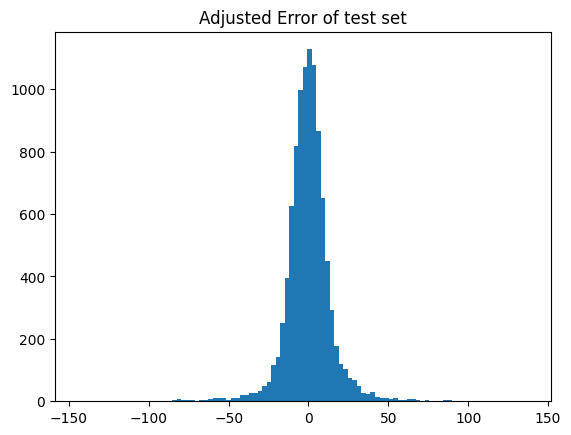

In [61]:
plt.hist(df_comp_test['ccs_diff'], bins = 100)
plt.title('Adjusted Error of test set')
plt.show()

In [62]:
print(df_comp_test['IM_diff'].mean())
print(df_comp_test['ccs_diff'].mean())

-0.00026729083274068614
-0.11812875393716316


In [14]:
# predict
prediction = models.predict_mobility(df_comp)

2024-07-23 13:16:18> Predicting mobility ...


 11%|█         | 5/46 [1:06:30<9:05:21, 798.09s/it]


In [29]:
%run evaluation_methods.ipynb
df_comp_trans = error(df_mods, prediction)

In [30]:
df_comp_trans.to_csv('comparisons/comp_all_trans.txt', sep = '\t')

In [5]:
df_comp_trans = pd.read_csv('comparisons/comp_all_trans.txt', sep = '\t')

In [11]:
print(df_comp_trans['ccs_diff'].mean())
print(df_comp_trans['ccs_diff'].std())

-0.5108401926079238
15.629827147972138


In [6]:
print(df_comp_trans['IM_diff'].mean())
print(df_comp_trans['IM_diff'].std())

-0.001001653523426027
0.028085535568089876


In [18]:
# experiment differences
df_51 = df_comp_trans[df_comp_trans["Experiment"]=='P064051']#P064051
print(len(df_51))
print(df_51['ccs_diff'].mean())
print(df_51['ccs_diff'].std())
df_64 = df_comp_trans[df_comp_trans["Experiment"]=='P064064']#P064064
print(len(df_64))
print(df_64['ccs_diff'].mean())
print(df_64['ccs_diff'].std())
df_28 = df_comp_trans[df_comp_trans["Experiment"]=='P064428']#P064428
print(len(df_28))
print(df_28['ccs_diff'].mean())
print(df_28['ccs_diff'].std())

505480
4.354601692198667
15.059535810261943
436198
-6.603192506418983
13.80515627386754
454890
-0.07537594708105753
15.910892336027853


Text(0.5, 1.0, 'Adjusted Error(Transfer Learning)')

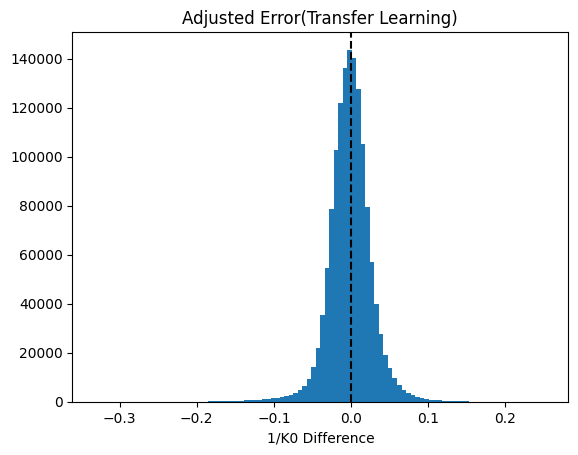

In [35]:
plt.hist(df_comp_trans['IM_diff'], bins=100)
plt.axvline(x = 0.0, c = 'black', linestyle = '--')
plt.xlabel('1/K0 Difference')
plt.title('Adjusted Error(Transfer Learning)')

In [16]:
print(df_comp_trans['ccs_diff'].abs().mean())

10.06373098443863


In [23]:
# percentile of CCS Difference
perc_low = np.percentile(df_comp_trans['ccs_diff'], 2.5)
perc_up = np.percentile(df_comp_trans['ccs_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-31.348391423895283, 30.216338894651553)


In [24]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

61.564730318546836


In [17]:
# percentile of im Difference
perc_low = np.percentile(df_comp_trans['IM_diff'], 2.5)
perc_up = np.percentile(df_comp_trans['IM_diff'], 97.5)
print(f'({perc_low}, {perc_up})')


(-0.05490183429897187, 0.05496947024448756)


In [7]:
print((perc_low)*(-1)+perc_up)
window = (perc_low)*(-1)+perc_up

NameError: name 'perc_low' is not defined

## Plots

C:\Users\cocob\AppData\Local\Temp\ipykernel_22344\3354442365.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Experiment', y='ccs_diff', data=df_comp_trans, scale='count')


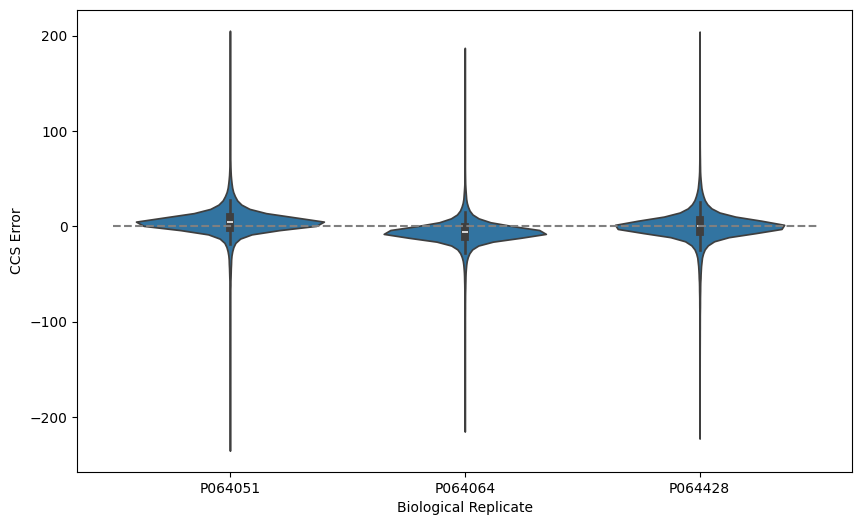

In [ ]:
# violin plot: experiment vs CCS error
plt.figure(figsize=(10, 6))
sns.violinplot(x='Experiment', y='ccs_diff', data=df_comp_trans, density_norm='count')

# Set plot labels and title
plt.xlabel('Biological Replicate')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 2.5, linestyles='--', colors='grey')

# Display the plot
plt.show()

2024-07-22 11:00:26> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\cocob\AppData\Local\Temp\ipykernel_22924\1662035779.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp_trans, scale='count', width=1.0)


2024-07-22 11:00:28> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


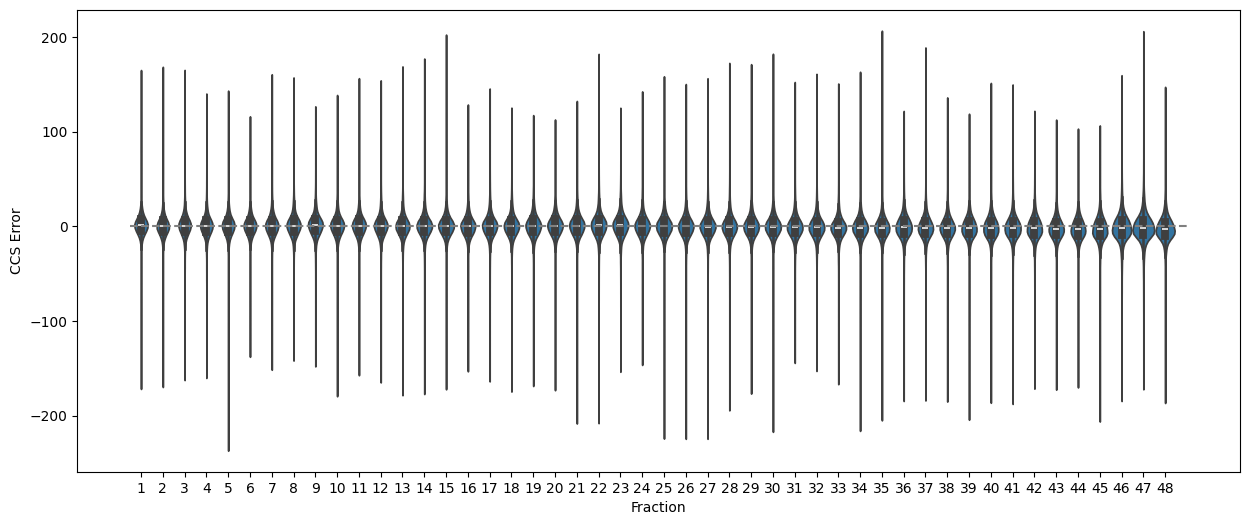

In [11]:
# violin plot: fractions vs CCS error
plt.figure(figsize=(15, 6))
sns.violinplot(x='Fraction', y='ccs_diff', data=df_comp_trans, scale='count', width=1.0)

# Set plot labels and title
plt.xlabel('Fraction')
plt.ylabel('CCS Error')
plt.hlines(y = 0.0, xmin = -0.5, xmax= 48, linestyles='--', colors='grey')

# Display the plot
plt.show()

Thoughts to further investigate:
- Look at the predictions which are futherst off from the mean

In [14]:
print(df_comp_trans[df_comp_trans['Experiment']=='P064051']['IM_diff'].mean())
print(df_comp_trans[df_comp_trans['Experiment']=='P064064']['IM_diff'].mean())
print(df_comp_trans[df_comp_trans['Experiment']=='P064428']['IM_diff'].mean())

0.00951010855665057
-0.014354252563112214
0.00012145645849469216


# Merge MaxQuant and AlphaBase

In [20]:
df_small = pd.read_csv('evidence_freshfrozen_small.txt', sep = '\t')
df_small['Original index'] = df_small.index
df_small = df_small.dropna(subset = ['Modified sequence', 'MS/MS scan number'])

C:\Users\cocob\AppData\Local\Temp\ipykernel_16472\3814694608.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_small = pd.read_csv('evidence_freshfrozen_small.txt', sep = '\t')


In [24]:
# try to work the psm reader on Dataframe
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.column_mapping['Original index'] = 'Original index'
mq_reader._translate_columns(df_small)
mq_reader._transform_table(df_small)
mq_reader._translate_decoy(df_small)
mq_reader._translate_score(df_small)
mq_reader._load_modifications(df_small)
mq_reader._translate_modifications()
mq_reader._post_process(df_small)
df_small_ab = mq_reader.psm_df

In [25]:
mq_reader.column_mapping

{'sequence': 'Sequence',
 'charge': 'Charge',
 'rt': 'Retention time',
 'ccs': 'CCS',
 'mobility': ['Mobility', 'IonMobility', 'K0', '1/K0'],
 'scan_num': ['Scan number', 'MS/MS scan number', 'Scan index'],
 'raw_name': 'Raw file',
 'precursor_mz': 'm/z',
 'score': 'Score',
 'proteins': 'Proteins',
 'genes': ['Gene Names', 'Gene names'],
 'decoy': 'Reverse',
 'intensity': 'Intensity',
 'original_index': 'original_index',
 'Original index': 'Original index'}

In [32]:
df_small_ab.columns

Index(['Sequence', 'Charge', 'Retention time', 'CCS', '1/K0',
       'MS/MS scan number', 'Raw file', 'm/z', 'Score', 'Proteins',
       'Gene names', 'Reverse', 'Intensity', 'spec_idx', 'Modifications alpha',
       'Modification sites', 'Length', 'Retention time norm'],
      dtype='object')

In [27]:
df_small_ab.columns = ['Sequence', 'Charge', 'Retention time', 'CCS', '1/K0', 'MS/MS scan number', 'Raw file',
       'm/z', 'Score', 'Proteins', 'Gene names', 'Decoy', 'Intensity', 'Original index',
       'spec_idx', 'Modifications alpha', 'Modification sites', 'Length', 'Retention time norm']

In [31]:
df_small.set_index('Original index', inplace=True)
df_small_ab.set_index('Original index', inplace = True)


KeyError: "None of ['Original index'] are in the columns"

In [58]:

df_merged = pd.merge(df_small, df_small_ab, on = ['Sequence', 'Charge', 'CCS', 'Score', 'Length', 'Retention time', 'Proteins', 'Gene names','1/K0' , 'MS/MS scan number', 'Raw file'
                                                  , 'm/z', 'Intensity', ], how = 'inner')

In [44]:
['Sequence', 'Length', 'Retention time', 'Score', 'Proteins', 'Gene names', 'Reverse', 'Charge', 'CCS', '1/K0', 'MS/MS scan number']

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Fraction', 'Experiment',
       'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/

In [30]:
print(~df_merged.columns.isin(df_small.columns))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True False  True]
